In [99]:
import os
import os, copy
import os.path
import subject2initial
from scipy import signal, interpolate
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from scipy.spatial import distance
import scipy.stats as stats
from scipy import fftpack
from datetime import datetime
from datetime import timedelta
import pylab
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, normaltest, anderson
from functools import reduce
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext

# Anomaly Detection Notebook

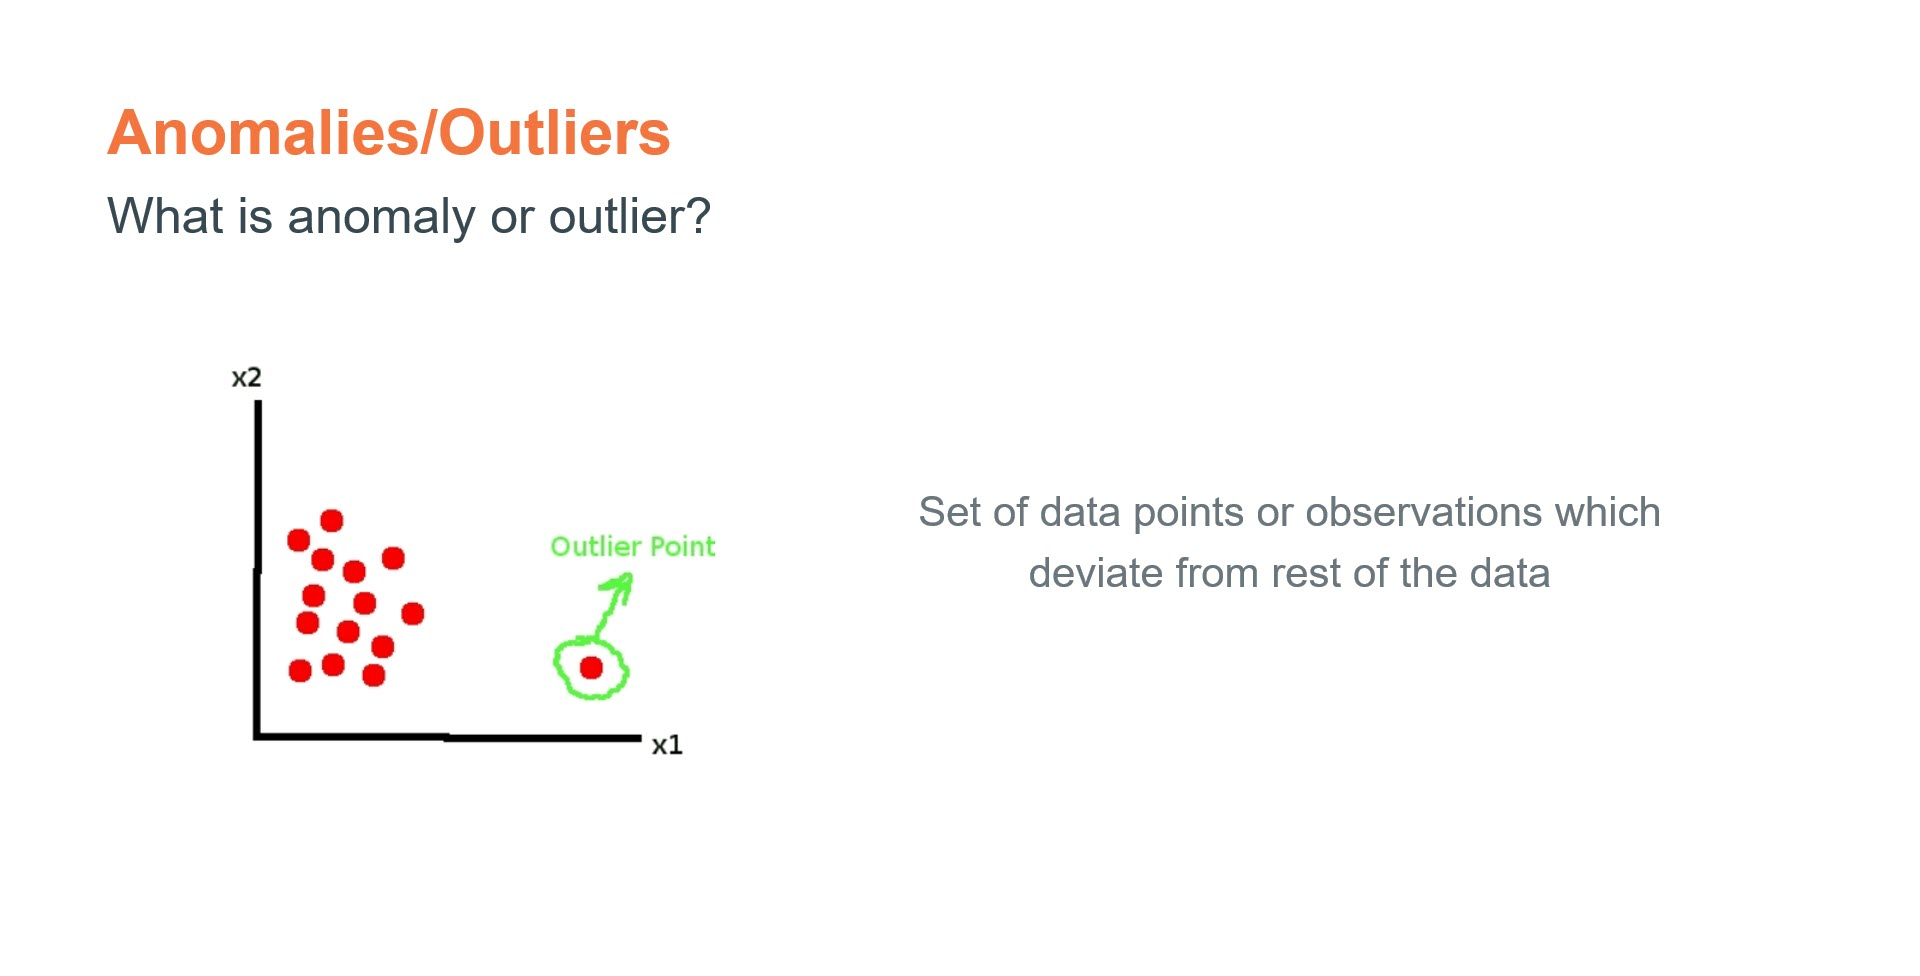

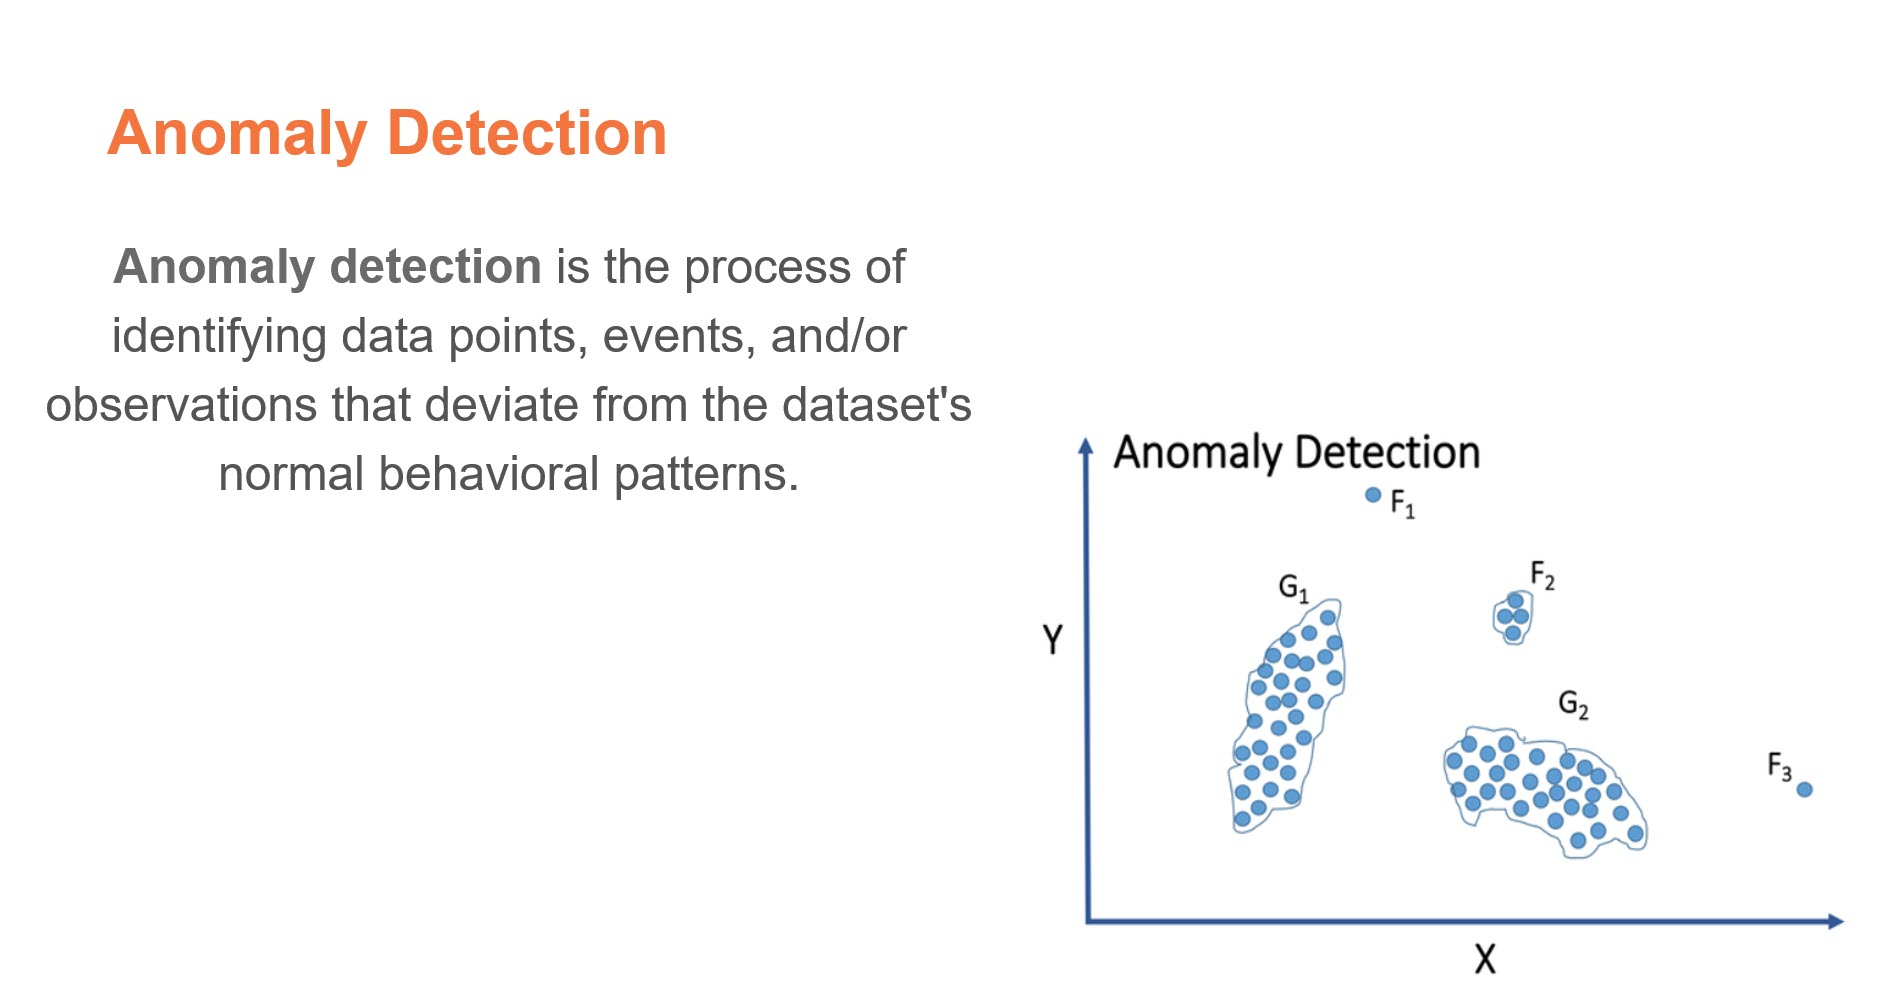

## Directory Setup and Data Loading

In [3]:
try:
    os.chdir(os.path.join(os.getcwd(), 'notebooks'))
    print(os.getcwd())
except:
    pass

strCurrentDirectory = os.getcwd()
print(strCurrentDirectory)

# "notebooks"ディレクトリよりも一階層上にいる場合はNotebooksフォルダに移動
if (strCurrentDirectory[-len("notebooks"):] != "notebooks") and (any("notebooks" in s for s in os.listdir())):
    os.chdir('notebooks')
    strCurrentDirectory = os.getcwd()
    print("notebooksフォルダの一階層上にいたのでnotebooksフォルダに移動しました。")

if strCurrentDirectory[-len("notebooks"):] == "notebooks":
    print("正常。作業ディレクトリがnotebooksフォルダに設定されています。")
else:
    print("エラー。作業ディレクトリがnotebooks以外に設定されています！現在の作業ディレクトリは" + strCurrentDirectory)

# %%
print(subject2initial.strInitialTest)


PATH_DATA_INT = subject2initial.funIsDirMakeDir(strPath="./data/interim")

C:\Users\SK250092\Desktop\Suzuki
エラー。作業ディレクトリがnotebooks以外に設定されています！現在の作業ディレクトリはC:\Users\SK250092\Desktop\Suzuki
イニシャルファイルからのテキスト読み込み
data\interim


## Configurations

In [4]:
np.set_printoptions(suppress=True)
outlier_threshold = 0.05
data_file = "SUZUKI_YSB-021_MRR_2016-04-20_06-27_0001.BLF.csv"
data_output_file = "pvalue_results.csv"

## Data Loading

In [5]:
pdCan = pd.read_csv(
    PATH_DATA_INT/"20190605_CAN/103.486_CAR1V21_HDD2/Job1/SUZUKI_YSB-021_MRR_2016-04-20_06-27_0001.BLF.csv",
    header=None,
    names=('zUnnamed', 'time1', 'time2', 'feature', 'value'))

In [6]:
# PATH_DATA_PRO_SUB2_PKL = subject2initial.funIsDirMakeDir(strPath  = "../data/processed/subject02/pickle")
# pdCan_multiFiles_keyFeatures = subject2initial.pickleReadOne(strObj="pdCan_multiFiles_keyFeatures", myPathlib = PATH_DATA_PRO_SUB2_PKL)
# pdCan_multiFiles_keyFeatures = pdCan_multiFiles_keyFeatures[pdCan_multiFiles_keyFeatures.columns.difference(['time1_unified'])]

### Helper Function Definitions


* adjusttime_resampling - to resample data based on mean from 100th of a second to 10th of a second
* calc_mu_sigma - calculate covariance matrix inverse(required for Mahalanobis Distance), mean, and the shape of the data
* calc_p_hoteling_t2 - calculate hoteling t-squared distribution for multivariate data using mahalanobis distance, and using F-distribution table, determines p-values

In [24]:
# --------------------------------------------------------------------------------------------------------------------------------------------
# adjusttime_resampling:
# to resample data based on mean from 100th of a second to 10th of a second
# Input: pdData(dataset)
# freq: frequency
#  adjust sensor time to 0.01 sec and resampling to 0.1sec 
# --------------------------------------------------------------------------------------------------------------------------------------------
def adjusttime_resampling(pdData, freq, method, decimal=2):
    pd_series = []
    date_time_index = [datetime.strptime(str(pdData["time1"].iloc[0]), '%Y%m%d%H%M') + timedelta(seconds=round(x,decimal)) for x in pdData["time2"]]
    pdData.index = date_time_index
    if method == "mean":
        pd_series = pdData["value"].resample(freq).mean()
    elif method == "sum":
        pd_series = pdData["value"].resample(freq).sum()

    return pd_series

# --------------------------------------------------------------------------------------------------------------------------------------------
# calc_mu_sigma:
# calculate covariance matrix inverse(required for Mahalanobis Distance), mean, and the shape of the data. These computations
# are required to calculate Mahalanobis distance
# Input: pd_data(dataset)
# Output: n - number of records
# k: number of dimensions
# means: pd_data each dimension means
# S: inverse of a covariance matrix computed for each pairwise combination of dimensions
# --------------------------------------------------------------------------------------------------------------------------------------------
def calc_mu_sigma(pd_data):            
    cov_mat = pd_data.cov()
    S = np.linalg.inv(cov_mat)
    n = pd_data.shape[0]
    k = pd_data.shape[1]
    return n, k, pd_data.mean(), S
# --------------------------------------------------------------------------------------------------------------------------------------------
# calc_p_hoteling_t2:
# Calculate Mahalanobis distance and scale it with hoteling t^2 scaling factor(degrees of freedom). Since Hoteling T^2 follows
# an F-distribution, we use it to compute probability of the computed value.
# Input: 
# data_list - multidimensional query point
# n - number of rows
# k - number of dimensions
# pd_data_mean - means of each dimension
# S - inverse of covariance matrix
# Output: 
# T2 - Hoteling T^2 value
# p_f - probability of T2 from an F-distribution
# --------------------------------------------------------------------------------------------------------------------------------------------
def calc_p_hoteling_t2(data_list, n, k, pd_data_mean, S):
    T2 = (n-k)/((n-1)*k) * (distance.mahalanobis(data_list, pd_data_mean, S))

    p_f = 1 - stats.f.cdf(T2,k,n-k)  
    return T2, p_f

# calc_p_md:
# Calculate Mahalanobis distance and pass the computed distance directly to a chi-squared distribution (without scaling)
# Input: 
# data_list - multidimensional query point
# n - number of rows
# k - number of dimensions
# pd_data_mean - means of each dimension
# S - inverse of covariance matrix
# Output: 
# MD - Mahalanobis Distance
# p_chi2 - probability of MD from chi-squared distribution
# --------------------------------------------------------------------------------------------------------------------------------------------
def calc_p_md(data_list, n, k, pd_data_mean, S):
    md = distance.mahalanobis(data_list, pd_data_mean, S)
# 
    p_chi2 = 1 - stats.chi2.cdf(md,k)
    
    return md, p_chi2

# mahalanobis:
# computes mahalanobis distance manually(without squaring it)
# Input: 
# x: dataset
# data: complete dataset(to compute means)
# cov: covariance matrix, if not provided will be computed
# Output: Mahalanobis distance for each point.
# --------------------------------------------------------------------------------------------------------------------------------------------
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
        
#     print(cov)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# cal_md:
# cal_md is an apply function to calculate mahalanobis distance for each different dataset built on different combinations
# of variables. It selects a subset of the data using the passed columns and computes distances
# Input: row - dataset columns
# Output: dist - distances in a pandas series object
# --------------------------------------------------------------------------------------------------------------------------------------------
def cal_md(row):
    col_idx = row[row].index.values
    normal = mts_normal
    ds = normal.iloc[:, col_idx]
    
    dist = pd.Series([distance.mahalanobis(list(mts_normal.iloc[idx]), pd_data_mean, S) for idx in range(mts_normal.shape[0])])
    return dist

# sn_ratio:
# signal to noise ratio computed for each run. It is used for Taguci systems in order to assess which combination of features gives a better signal to noise ratio (bigger the better)
# Input: Mahalanobis distances for each run
# Output: 
# signal to noise ratio for each run
# --------------------------------------------------------------------------------------------------------------------------------------------

def sn_ratio(runs):
    nRow = runs.shape[0]
    mat = 1/np.power(runs, 2)
    mat = mat.sum()
    mat = mat/nRow
    mat = -10 * np.log10(mat)
    return mat

# filtereddata:
# resample data by applying mean function.
# --------------------------------------------------------------------------------------------------------------------------------------------
#%%
method_dict ={'mean':['1EF57','1EF61','1B805','1B825','1B845','1B865'],'mean':['1EF37','11947']}

def filtered_data(df):
    initial = True
    for i in wheel_dict.keys():
        if(initial):
            data_samp = (pd.DataFrame(adjusttime_resampling(df[df.feature==i],'100L', 'mean' 
                                                           if(i in method_dict['mean']) else 'mean')))
#             print(wheel_dict[i])
            data_samp.rename(columns = {'value':wheel_dict[i]},inplace = True) 
            initial = False
        else:
            data_samp[wheel_dict[i]] = (adjusttime_resampling(df[df.feature==i],'100L', 'mean' 
                                                             if(i in method_dict['mean']) else 'mean'))

#             print(wheel_dict[i])
            
            
    data_samp.dropna(inplace = True)
    return(data_samp)


### Wheel sensor data size

In [25]:
# checking the size of data for each wheel key ids
wheel_dict =     {'11947': 'Steering_Wheel_Absolute_Angle',
             '1EF57': 'Acceleration_Sensor_Value',
             '1EF37': 'Yaw_Rate',
             '1EF61': 'Lateral_Sensor_Value',
             '1B805': 'Wheel Speed(Front Right)',
             '1B825': 'Wheel Speed(Front Left)',
             '1B845': 'Wheel Speed(Rear Right)',
             '1B865': 'Wheel Speed(Rear Left)',
             '31417': 'Vehicle_Speed'
                 }
#print (pdCan)
for key,val in wheel_dict.items():
    pdTemp = pdCan.query("feature == '" + key + "'")
    print("Key: {0}, Val: {1}, Size: {2}".format(key,val,pdTemp.shape)) # return total rows and columns of each feature 

Key: 11947, Val: Steering_Wheel_Absolute_Angle, Size: (59863, 5)
Key: 1EF57, Val: Acceleration_Sensor_Value, Size: (29949, 5)
Key: 1EF37, Val: Yaw_Rate, Size: (29949, 5)
Key: 1EF61, Val: Lateral_Sensor_Value, Size: (29949, 5)
Key: 1B805, Val: Wheel Speed(Front Right), Size: (59897, 5)
Key: 1B825, Val: Wheel Speed(Front Left), Size: (59897, 5)
Key: 1B845, Val: Wheel Speed(Rear Right), Size: (59897, 5)
Key: 1B865, Val: Wheel Speed(Rear Left), Size: (59897, 5)
Key: 31417, Val: Vehicle_Speed, Size: (5990, 5)


### Wheel Sensor Descriptive Statistics

In [26]:
# Wheel Speed
pdWheels =pd.DataFrame()
key_list = list(wheel_dict.keys()) 
for key in key_list:
    pdTemp = pdCan.query("feature == '" + key + "'")
    pdWheels = pdWheels.append(pdTemp)
    print(format(pdTemp["value"].describe()))

count    59863.000000
mean        12.061395
std        121.504951
min       -568.100000
25%         -7.700000
50%          1.400000
75%          4.000000
max        581.100000
Name: value, dtype: float64
count    29949.000000
mean        -0.011378
std          0.647505
min         -3.687500
25%         -0.187500
50%          0.000000
75%          0.062500
max          3.375000
Name: value, dtype: float64
count    29949.000000
mean         0.251112
std          4.697789
min        -35.770000
25%         -0.145000
50%          0.010000
75%          0.080000
max         35.455000
Name: value, dtype: float64
count    29949.000000
mean         0.026182
std          0.313313
min         -3.500000
25%         -0.062500
50%          0.000000
75%          0.062500
max          3.187500
Name: value, dtype: float64
count    59897.000000
mean       217.681107
std        267.340856
min          0.000000
25%          0.000000
50%         40.500000
75%        420.500000
max        879.250000
Name: va

In [27]:
data_sampled = filtered_data(pdCan)

      Wheel Speed(Front Right) Wheel Speed(Front Left)  \
count               5,983.0000              5,983.0000   
mean                    0.0000                  0.0000   
std                     2.1102                  2.0995   
min                   -13.0000                -11.9250   
25%                    -0.4000                 -0.4000   
50%                     0.0000                  0.0000   
75%                     0.1250                  0.1250   
max                    11.9000                 12.2000   

      Wheel Speed(Rear Right) Wheel Speed(Rear Left)  
count              5,983.0000             5,983.0000  
mean                   0.0000                 0.0000  
std                    2.1155                 2.0905  
min                  -12.6000                -9.2500  
25%                   -0.4250                -0.4000  
50%                    0.0000                 0.0000  
75%                    0.1000                 0.0750  
max                   12.0500        

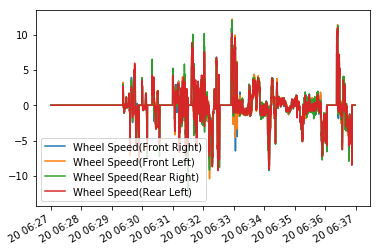

In [28]:
wheel_cols = ['Wheel Speed(Front Right)', 'Wheel Speed(Front Left)', 'Wheel Speed(Rear Right)', 'Wheel Speed(Rear Left)']
pdMultiData = data_sampled[wheel_cols].apply(lambda x: x.diff())# find difference between 2 sets
pdMultiData[wheel_cols] = pdMultiData[wheel_cols].fillna(0)
pdMultiData[wheel_cols].plot()
print(pdMultiData[wheel_cols].describe().apply(lambda x: x.map('{:,.4f}'.format)))

In [29]:
pdMultiData.rename(columns = {
    'Acceleration_Sensor_Value': 'ASV'
                              , 'Lateral_Sensor_Value':'LSV'
                              , 'Vehicle_Speed': 'VS'
                              , 'Wheel Speed(Front Left)':'FL'
                              , 'Wheel Speed(Front Right)': 'FR'
                              , 'Wheel Speed(Rear Left)':'RL'
                              , 'Wheel Speed(Rear Right)' : 'RR'
                              , 'Yaw_Rate': 'YR'
                             }, inplace = True)

## Univariate Analysis (Normalcy Test)
### Data Distributions for Individual Wheel RPMs
### Histogram Plots

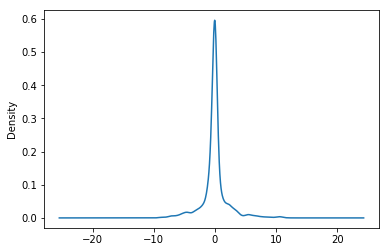

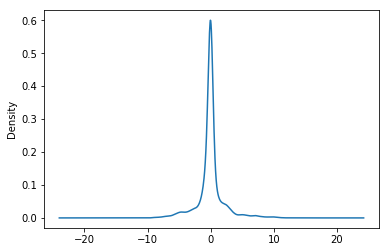

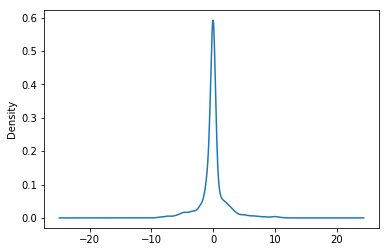

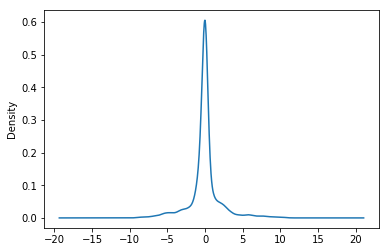

In [30]:
pdMultiData['FR'].plot(kind='kde')
plt.show()
pdMultiData['FL'].plot(kind = 'kde')
plt.show()
pdMultiData['RR'].plot(kind = 'kde')
plt.show()
pdMultiData['RL'].plot(kind = 'kde')
plt.show()

#### QQ Plot (Normalcy Check)

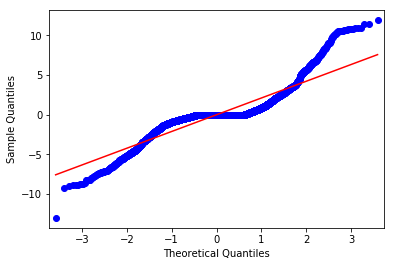

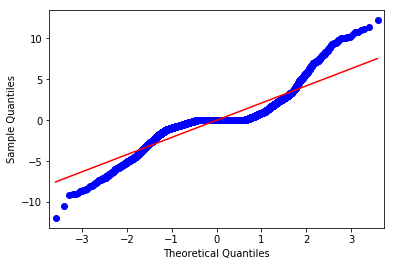

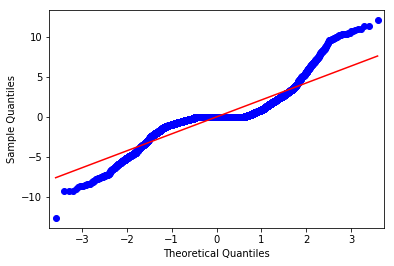

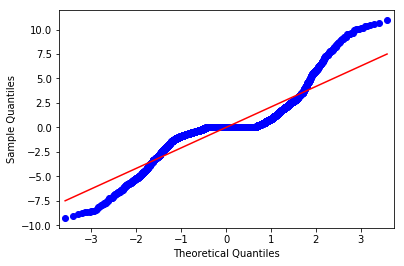

In [31]:
qqplot(pdMultiData['FR'], line='s')
plt.show()

qqplot(pdMultiData['FL'], line='s')
plt.show()

qqplot(pdMultiData['RR'], line='s')
plt.show()

qqplot(pdMultiData['RL'], line='s')
plt.show()

#### Shapiro Wilkes Test

In [32]:
stat, p = shapiro(pdMultiData['FR'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('FR looks Gaussian (fail to reject H0)')
else:
    print('FR does not look Gaussian (reject H0)')

stat, p = shapiro(pdMultiData['FL'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('FL looks Gaussian (fail to reject H0)')
else:
    print('FL does not look Gaussian (reject H0)')

stat, p = shapiro(pdMultiData['RR'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('RR looks Gaussian (fail to reject H0)')
else:
    print('RR does not look Gaussian (reject H0)')

stat, p = shapiro(pdMultiData['RL'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('RL looks Gaussian (fail to reject H0)')
else:
    print('RL does not look Gaussian (reject H0)')

Statistics=0.787, p=0.000
FR does not look Gaussian (reject H0)
Statistics=0.790, p=0.000
FL does not look Gaussian (reject H0)
Statistics=0.786, p=0.000
RR does not look Gaussian (reject H0)
Statistics=0.789, p=0.000
RL does not look Gaussian (reject H0)


C:\Users\SK250092\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\SK250092\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\SK250092\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\SK250092\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### K^2 Test

In [33]:
stat, p = normaltest(pdMultiData['FR'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('FR looks Gaussian (fail to reject H0)')
else:
	print('FR does not look Gaussian (reject H0)')

stat, p = normaltest(pdMultiData['FL'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('FL looks Gaussian (fail to reject H0)')
else:
	print('FL does not look Gaussian (reject H0)')
    
stat, p = normaltest(pdMultiData['RR'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('RR looks Gaussian (fail to reject H0)')
else:
	print('RR does not look Gaussian (reject H0)')
    
stat, p = normaltest(pdMultiData['RL'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('RL looks Gaussian (fail to reject H0)')
else:
	print('RL does not look Gaussian (reject H0)')

Statistics=1134.632, p=0.000
FR does not look Gaussian (reject H0)
Statistics=1065.402, p=0.000
FL does not look Gaussian (reject H0)
Statistics=1123.830, p=0.000
RR does not look Gaussian (reject H0)
Statistics=1021.259, p=0.000
RL does not look Gaussian (reject H0)


#### Anderson-Darling Test

In [34]:
result = anderson(pdMultiData['FR'])
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, FR looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, FR does not look normal (reject H0)' % (sl, cv))

result = anderson(pdMultiData['FL'])
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, FL looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, FL does not look normal (reject H0)' % (sl, cv))

result = anderson(pdMultiData['RR'])
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, RR looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, RR does not look normal (reject H0)' % (sl, cv))

        
result = anderson(pdMultiData['RL'])
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, RL looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, RL does not look normal (reject H0)' % (sl, cv))

Statistic: 522.720
15.000: 0.576, FR does not look normal (reject H0)
10.000: 0.656, FR does not look normal (reject H0)
5.000: 0.786, FR does not look normal (reject H0)
2.500: 0.917, FR does not look normal (reject H0)
1.000: 1.091, FR does not look normal (reject H0)
Statistic: 522.650
15.000: 0.576, FL does not look normal (reject H0)
10.000: 0.656, FL does not look normal (reject H0)
5.000: 0.786, FL does not look normal (reject H0)
2.500: 0.917, FL does not look normal (reject H0)
1.000: 1.091, FL does not look normal (reject H0)
Statistic: 518.962
15.000: 0.576, RR does not look normal (reject H0)
10.000: 0.656, RR does not look normal (reject H0)
5.000: 0.786, RR does not look normal (reject H0)
2.500: 0.917, RR does not look normal (reject H0)
1.000: 1.091, RR does not look normal (reject H0)
Statistic: 528.756
15.000: 0.576, RL does not look normal (reject H0)
10.000: 0.656, RL does not look normal (reject H0)
5.000: 0.786, RL does not look normal (reject H0)
2.500: 0.917, RL

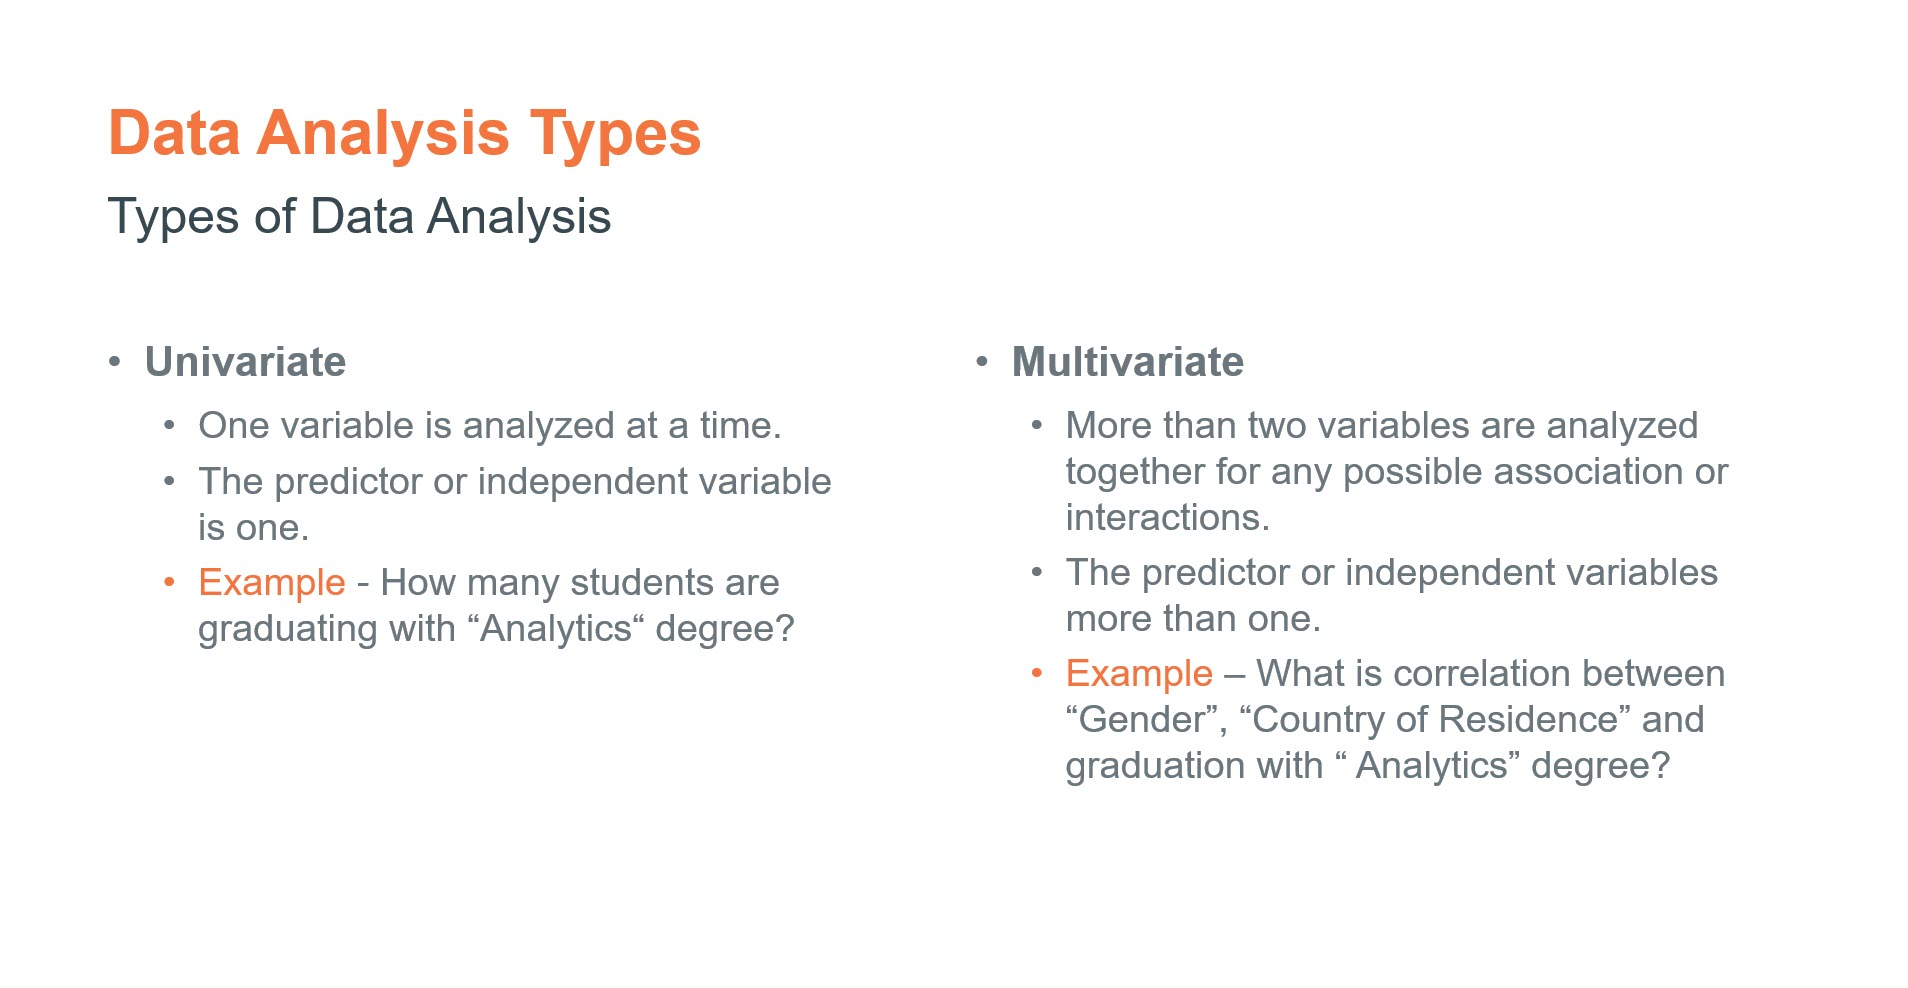

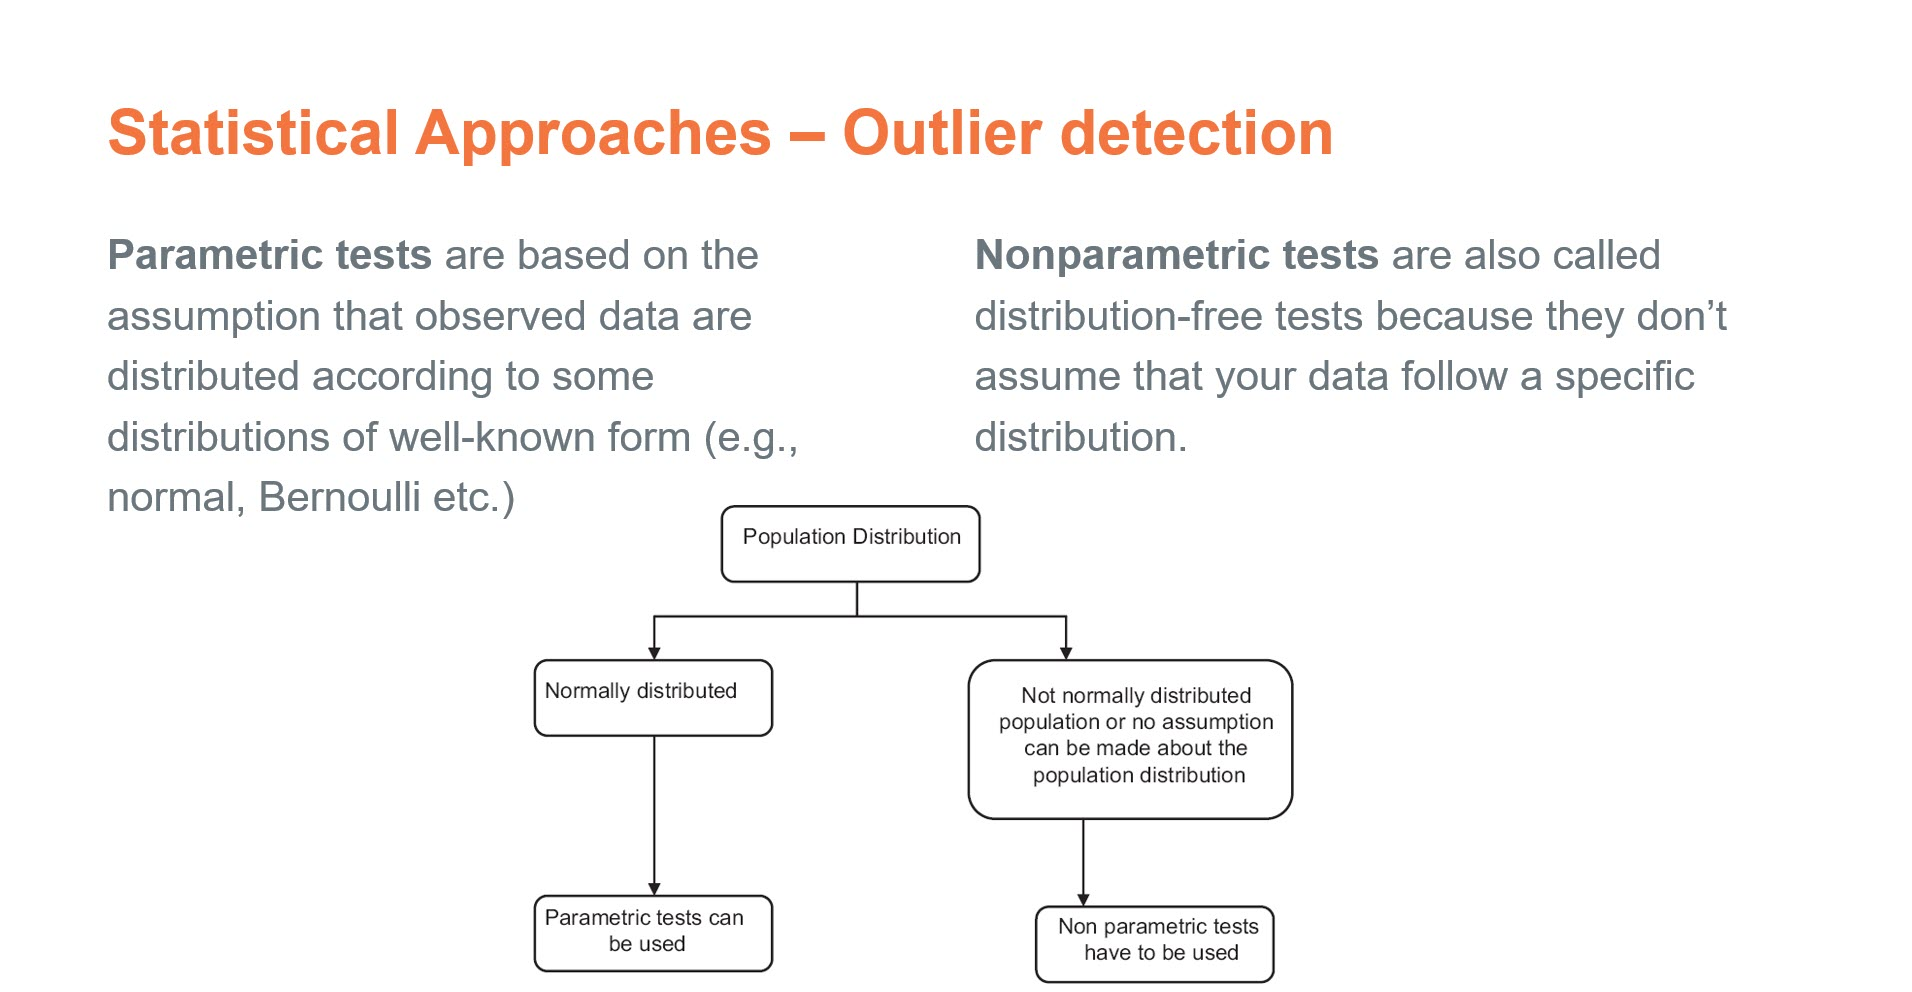

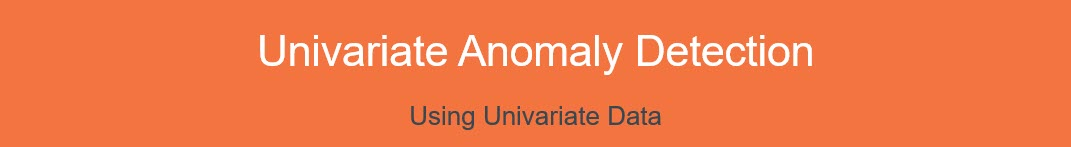

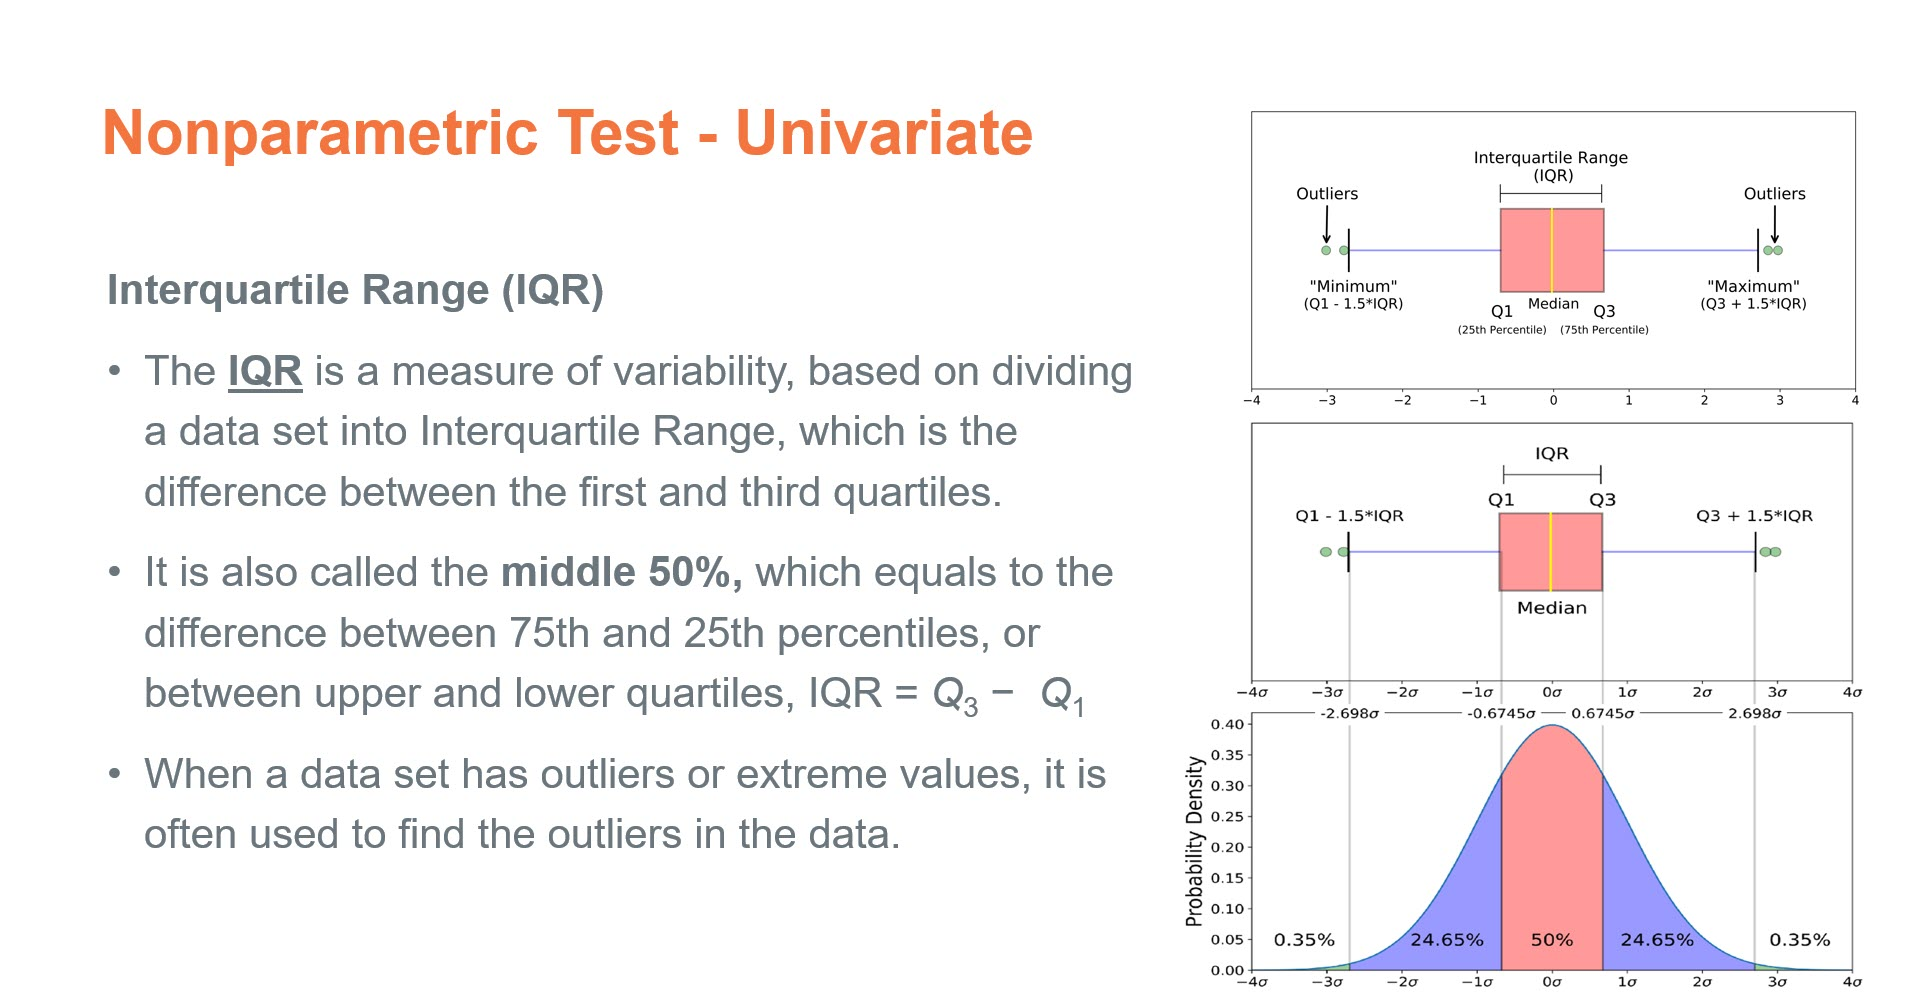

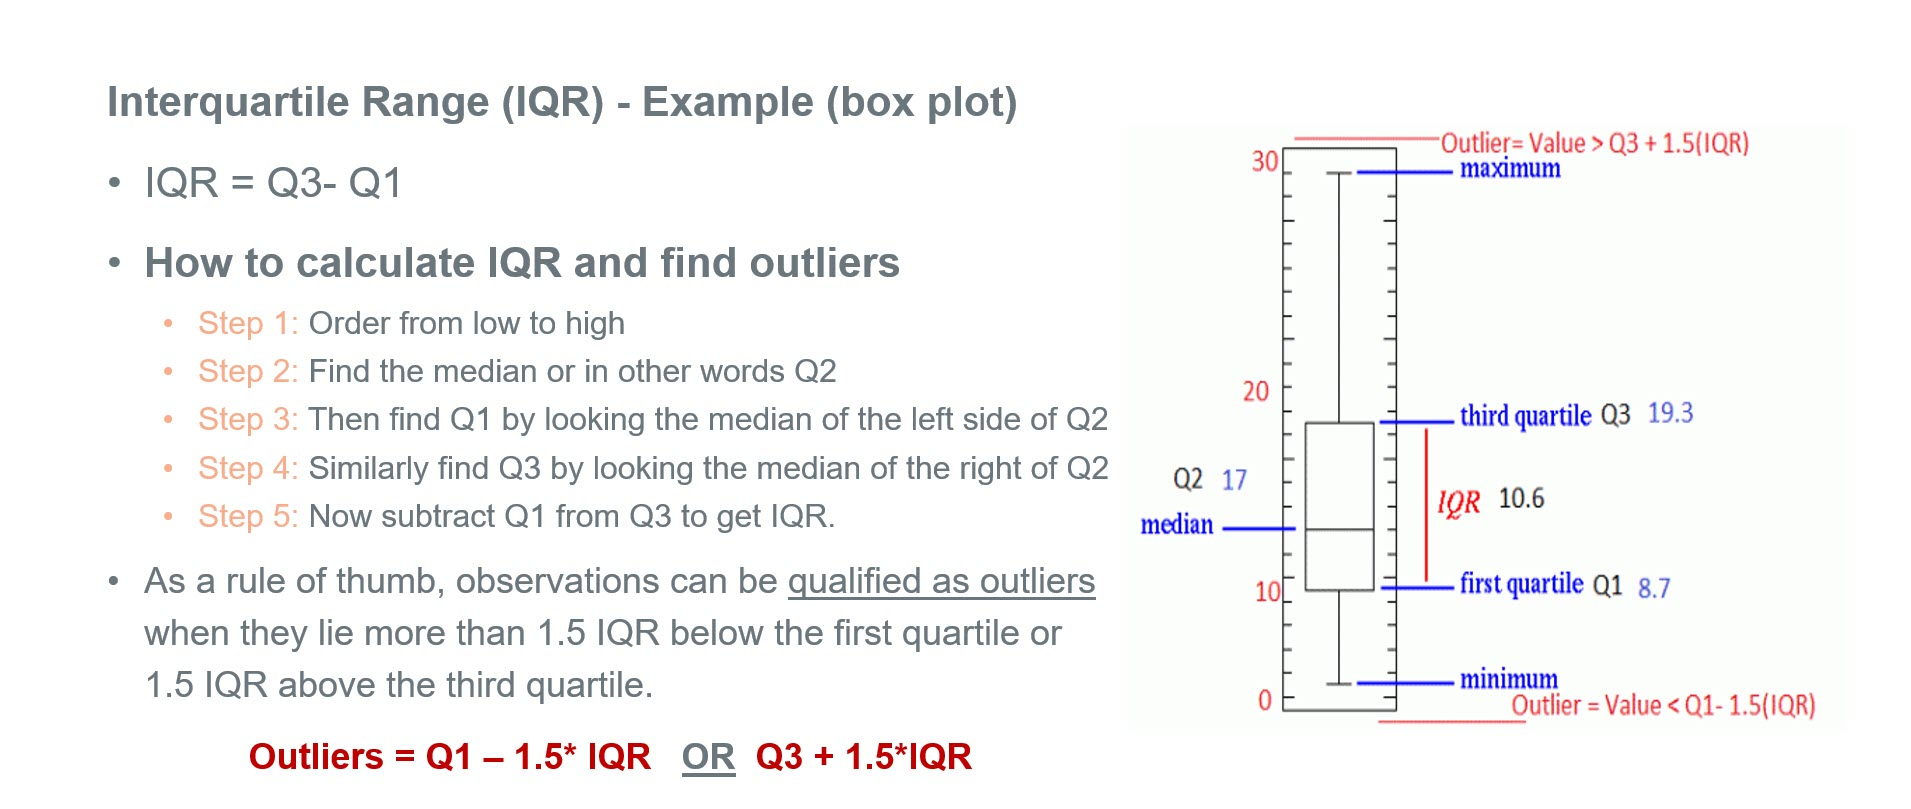

<function matplotlib.pyplot.show(*args, **kw)>

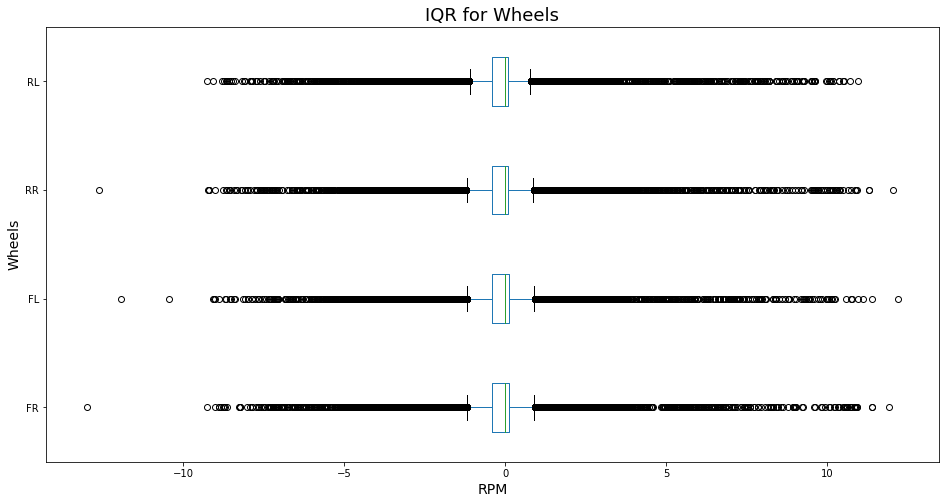

In [35]:
#Function: This function identifies the outliers/anomalies in each wheel separately using IQR approach 
#Input:    The arguments of the function take "Data of a Wheel" e.g Front Righ wheel
#Output:   Returns the values of all the outliers(anomalies)
#---------------------------------------------------------------------------------------------------------------------------
def nonparam_uni_IQR_outliers(data):
    #Find the Q3 and Q1 of data
    q25, q75 = np.percentile(data, 25), np.percentile(data, 75)
    #Find IQR = Q3 − Q1
    iqr = q75 - q25
    # calculate the outlier cutoff (1.5 greater than IQR)
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    # identify outliers
    return pd.DataFrame(data.iloc[np.where(data.gt(upper) | data.lt(lower))])#get greater than and lower than upper/lower limits
#----------------------------------------------------------------------------------------------------------------------------
#call the IQR function for each wheel
fr_outliers = nonparam_uni_IQR_outliers(pdMultiData['FR'])
fl_outliers = nonparam_uni_IQR_outliers(pdMultiData['FL'])
rr_outliers = nonparam_uni_IQR_outliers(pdMultiData['RR'])
rl_outliers = nonparam_uni_IQR_outliers(pdMultiData['RL'])

#box Plot the data of each wheel to visualize the outliers
df = pdMultiData
new_multi1_df=pd.DataFrame(columns=['FR', 'FL','RR','RL'], data=df.values, index=df.index)
new_multi1_df.plot(kind = 'box', figsize=[16,8], vert=False)
plt.title('IQR for Wheels', fontsize=18)
plt.xlabel('RPM', fontsize=14)
plt.ylabel('Wheels', fontsize=14)
plt.show

- The above plot shows the distribution of RPM values for each wheel (Front-Right(FR), Front-Left(FL), Rear-Rigt(RR), Rear-Left(RL))
- The blue line box represents the Q1 to Q3 (50%) values, whereas the green line represents the median(Q2).
- The black dots are all the outliers 
        Outliers = Values lower than ( Q1 – 1.5 x IQR )     OR   
                   Values greater than (Q3 + 1.5 x IQR)

#### Common IQR outliers

<function matplotlib.pyplot.show(*args, **kw)>

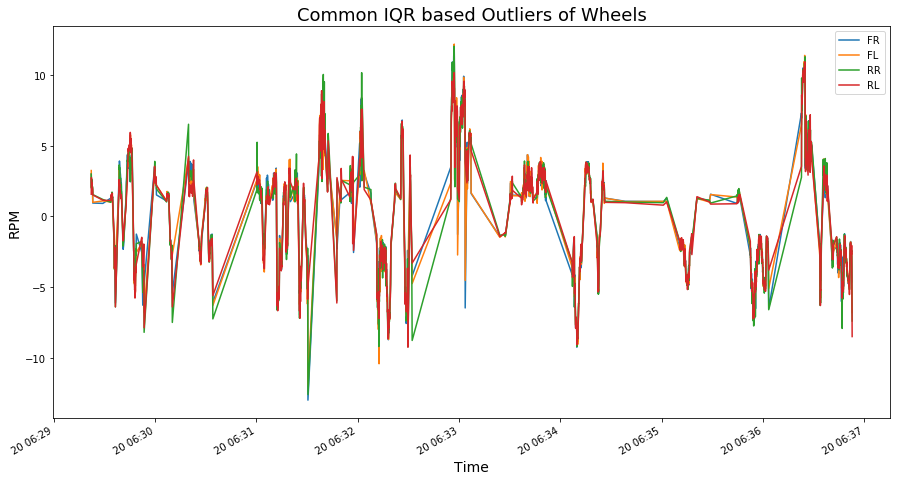

In [36]:
#Plot the common outliers in 4 wheels
dfs = [fr_outliers, fl_outliers, rr_outliers, rl_outliers]
common_outliers = reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True), dfs)
common_outliers.plot(figsize=(15,8))
plt.title('Common IQR based Outliers of Wheels', fontsize=18)
plt.ylabel('RPM', fontsize=14)
plt.xlabel('Time',fontsize=14)
plt.show

- The above graph shows IQR based outlier values of each wheel (Front-Right(FR), Front-Left(FL), Rear-Rigt(RR), Rear-Left(RL))
- The common outliers between each wheel overlap

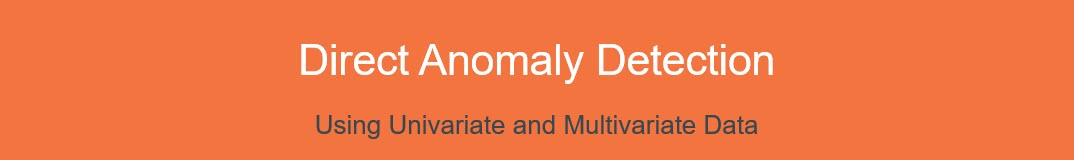

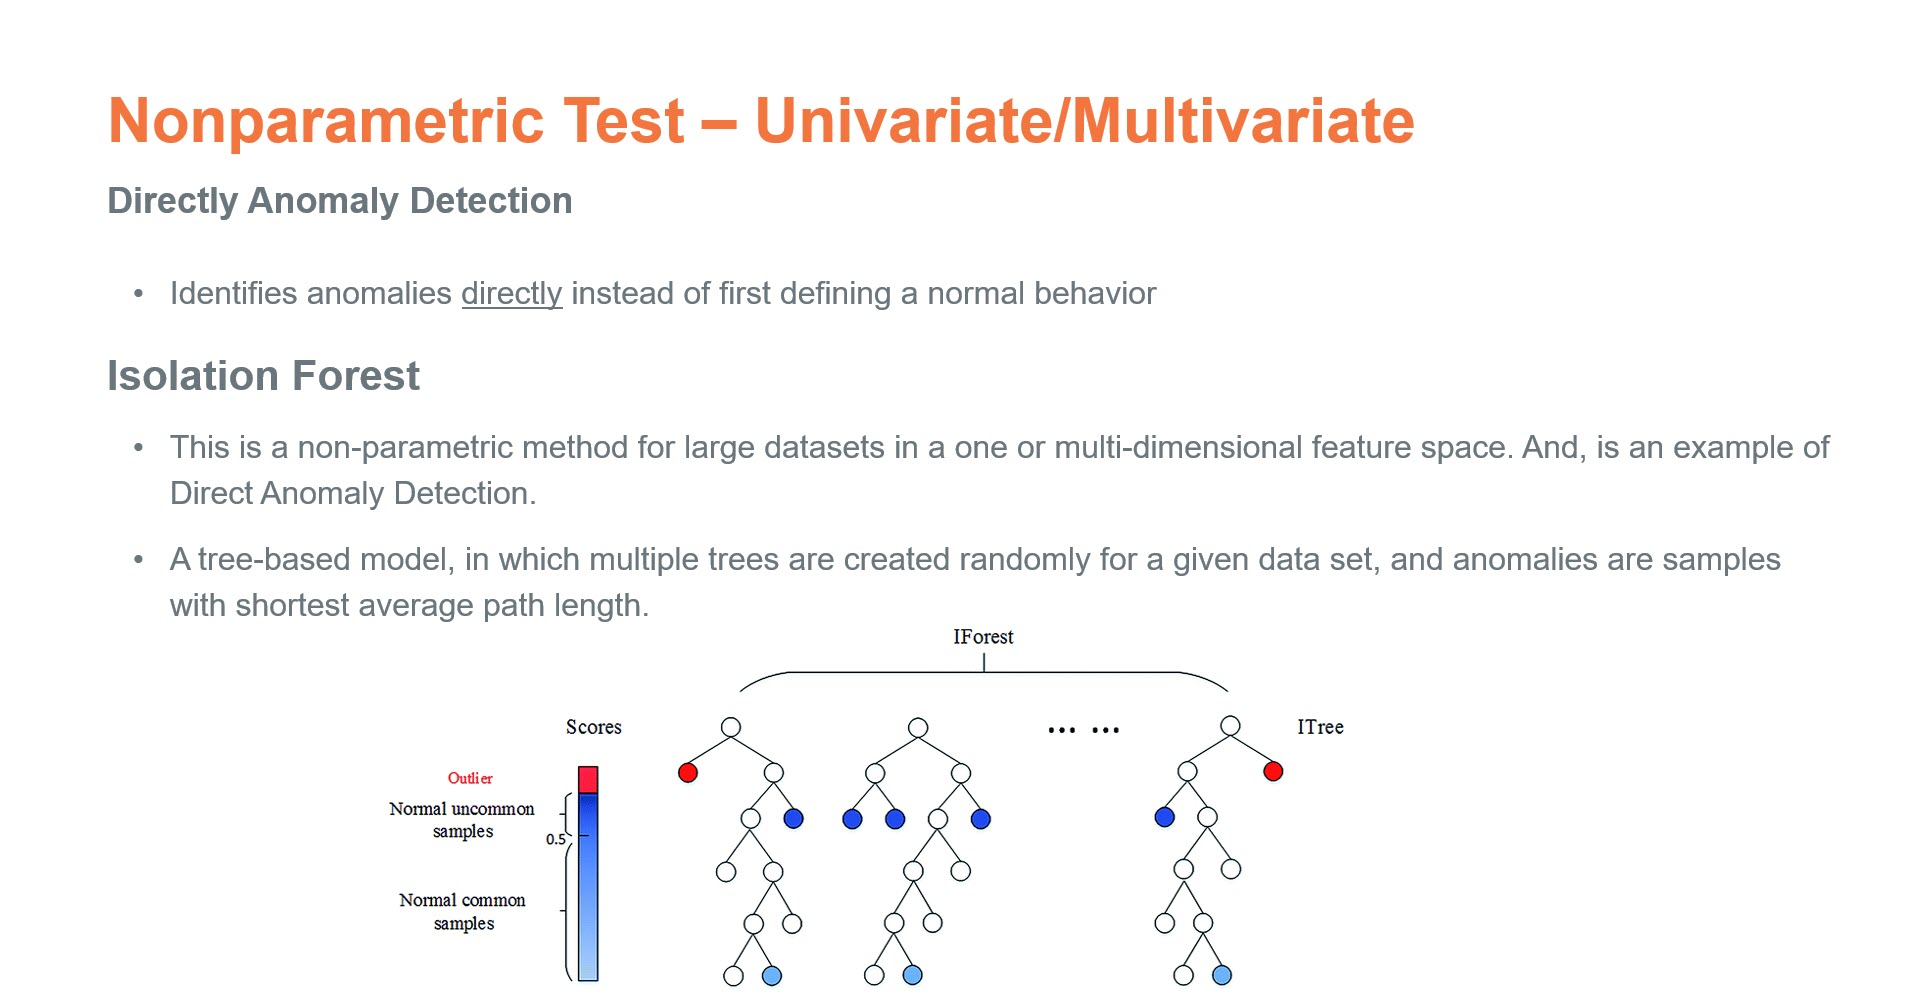

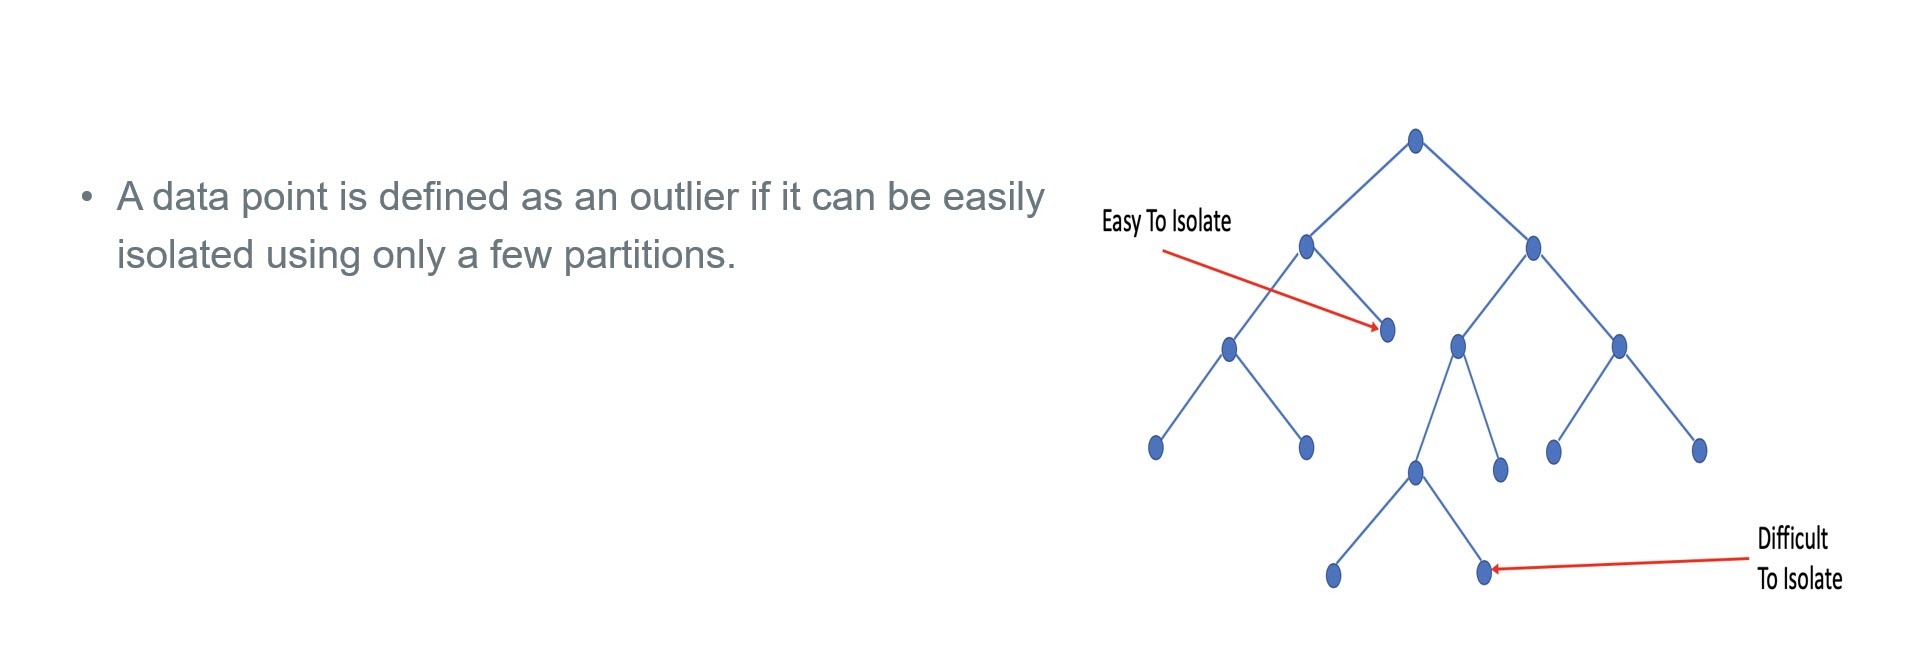

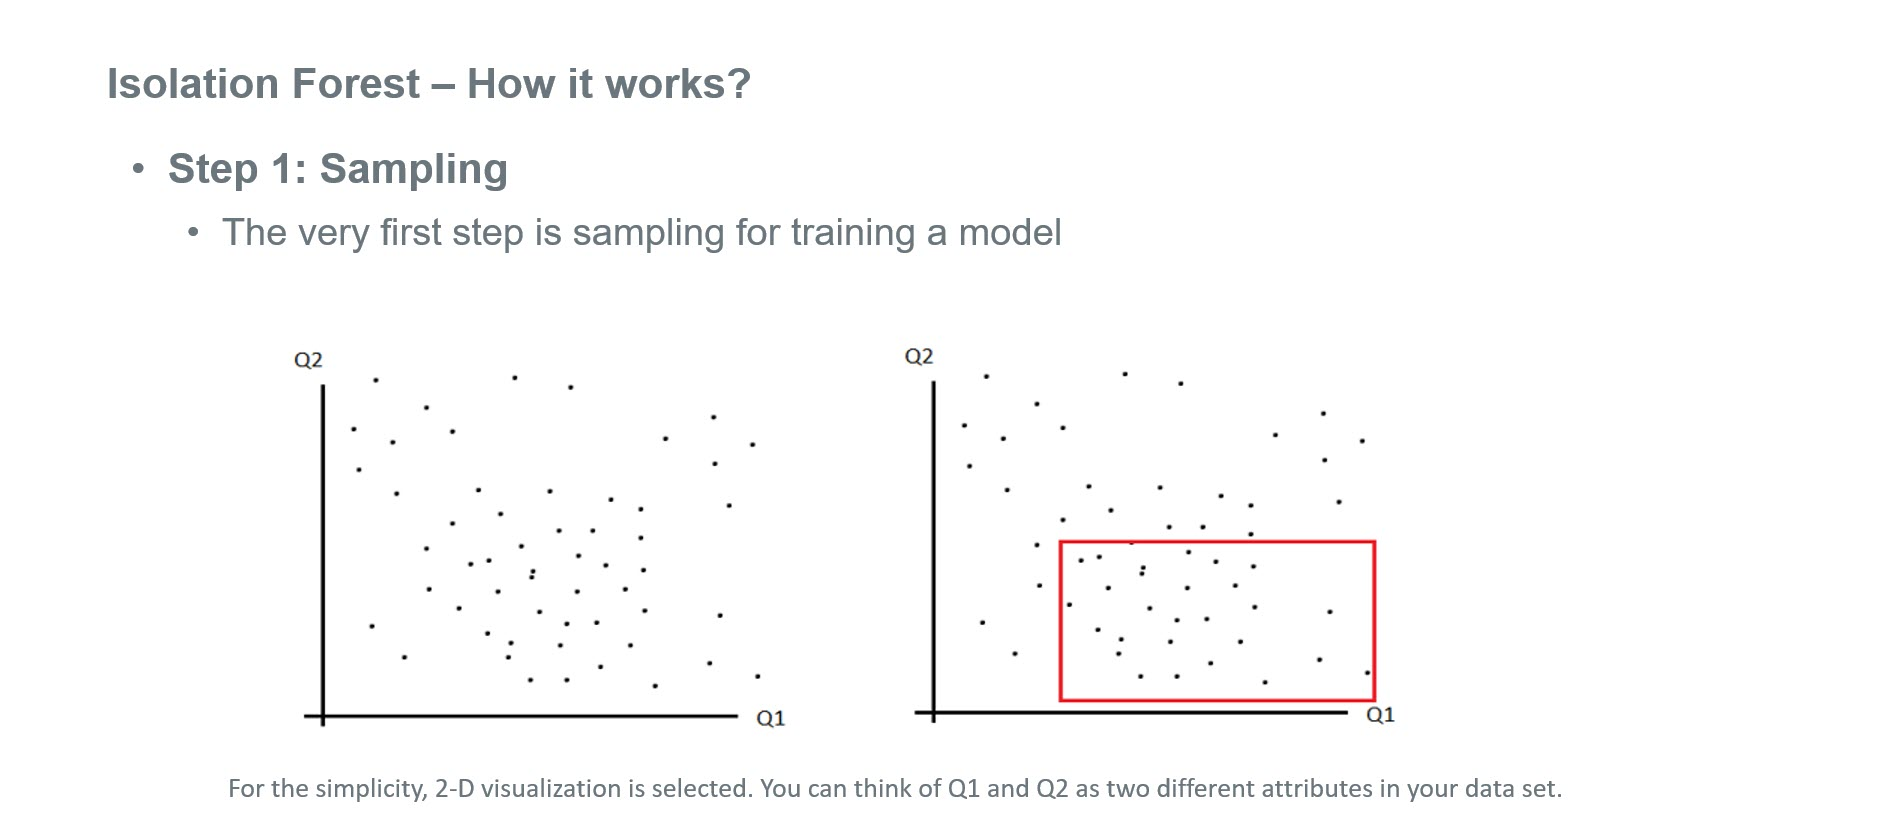

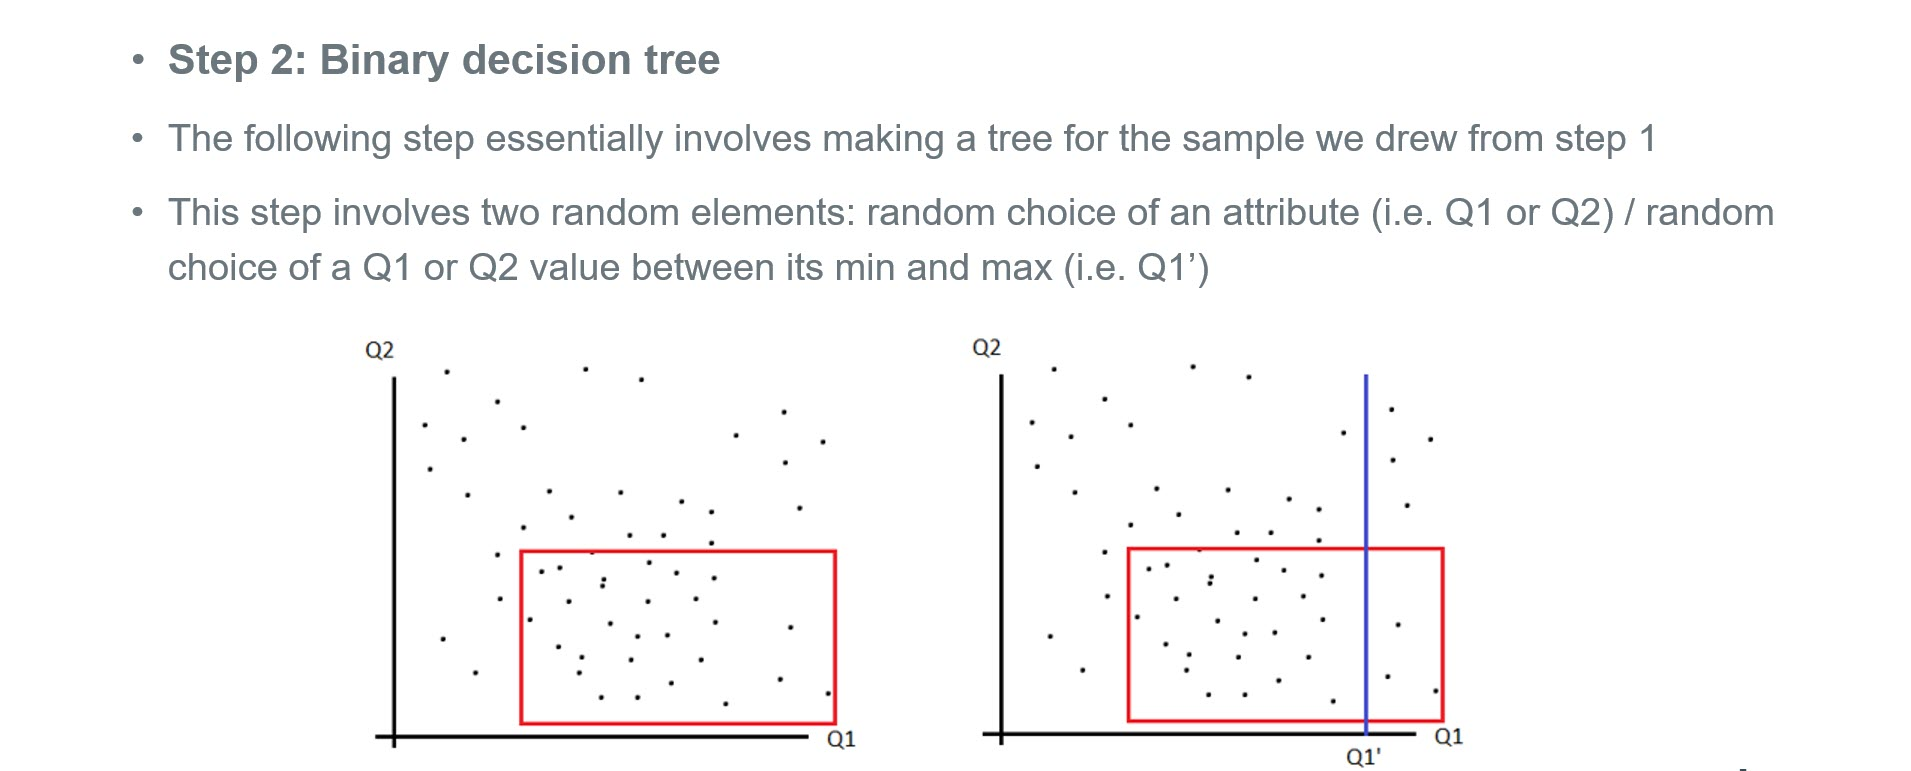

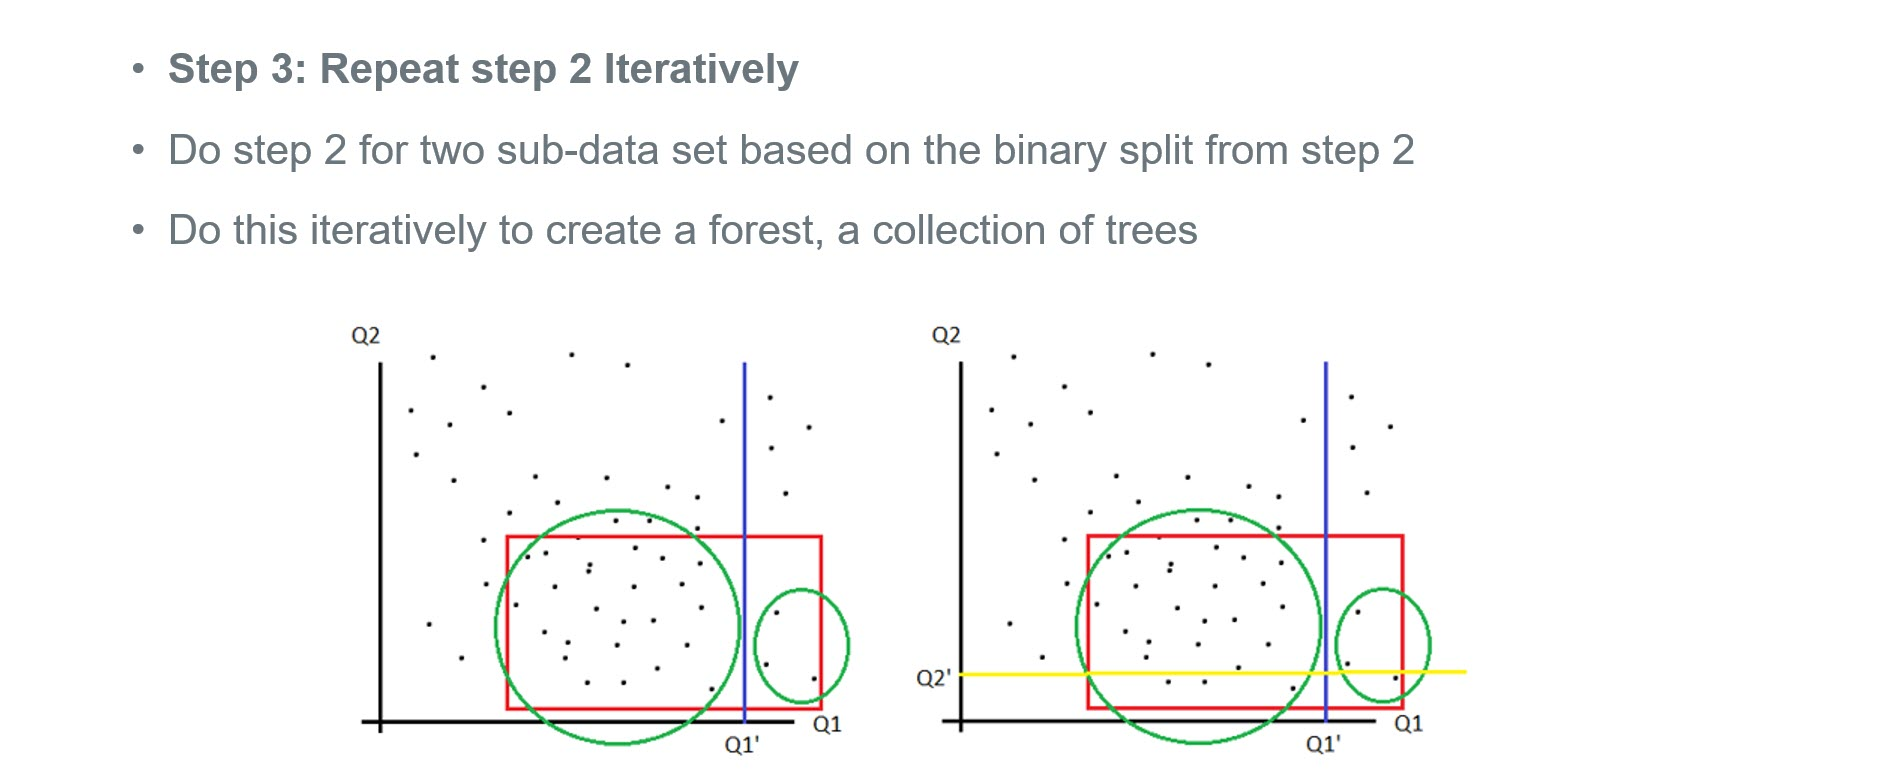

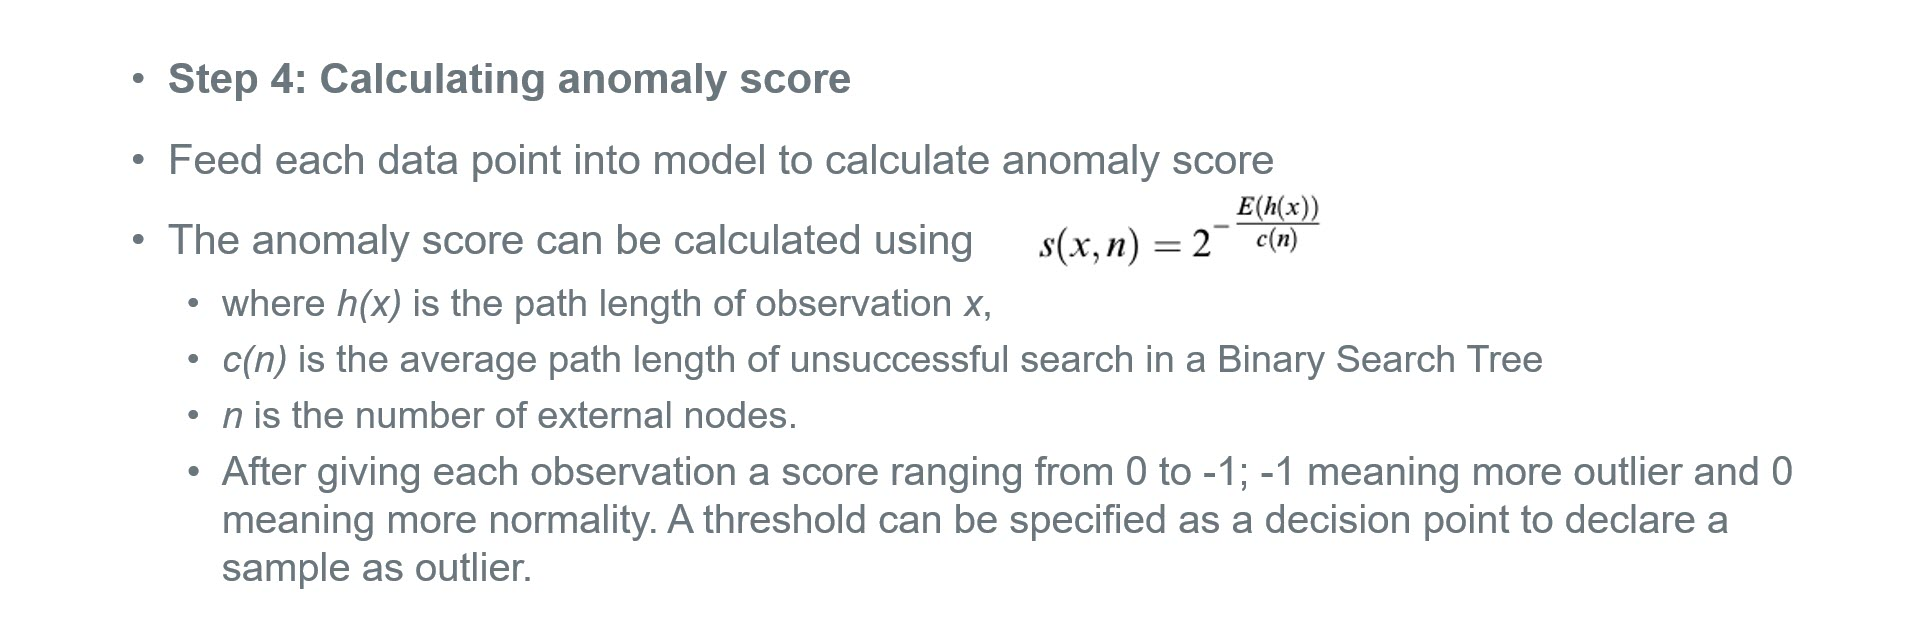

#### Implementation of Isolation forest for Univariate data 


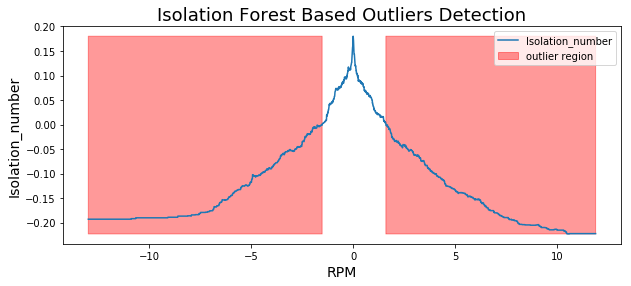

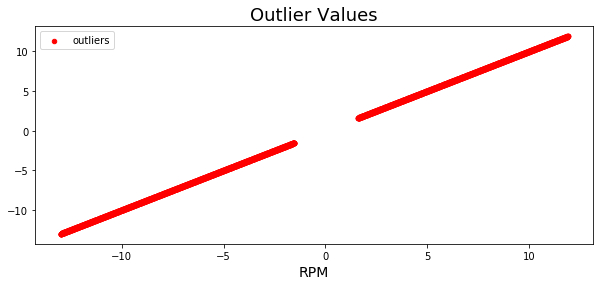

In [37]:
#Function: This function identifies the outliers/anomalies in each wheel separately using Isolation Forest approach 
#Input:    The arguments of the function take "Data of a Wheel" e.g Front Righ wheel
#Output:   Returns the values of all the outliers(anomalies)
#---------------------------------------------------------------------------------------------------------------------------

def nonparam_uni_Isolation_Forest(data):
    rng = np.random.RandomState(1042)
    # fit the model by using function I_Forest = IsolationForest()
    # attributes can also be adjusted according to requirements
    I_Forest = IsolationForest(behaviour='new', max_samples=100, random_state=rng, contamination='auto')
    # Input the sample,Reshape (-1,1) means data rows unknown and column 1
    I_Forest.fit(data.values.reshape(-1, 1))
    #linspace function produces a evenly spaced observations within a defined interval.
    xx = np.linspace(data.min(), data.max(), len(data)).reshape(-1,1)
    # Find Isolation Number
    Isolation_number = I_Forest.decision_function(xx)
    #Predict if a particular sample is an outlier or not.(Returns (+1 or -1))
    predict_outlier = I_Forest.predict(xx)
    # create a data frame containing outlier values
    new_df= pd.DataFrame.from_records(xx)    
    outliers=new_df.iloc[predict_outlier==-1]
    #view the observations graphically
    nonparam_uni_Isolation_Forest_visualize(xx, Isolation_number, predict_outlier,outliers)
    return(outliers)
#--------------------------------------------------------------------------------------------------------------------------
#Function: This function plots the outliers/anomalies in each wheel separately using Isolation Forest approach 
#Input:    The arguments of the function take Data of a Wheel, Isolation Number, outlier predictions and the values of outliers
#Output:   Plots the graphs
#---------------------------------------------------------------------------------------------------------------------------
#Visualize
def nonparam_uni_Isolation_Forest_visualize(xx,Isolation_number, predict_outlier,outliers):
    plt.figure(figsize=(10,4))
    plt.plot(xx, Isolation_number, label='Isolation_number')
    plt.fill_between(xx.T[0], np.min(Isolation_number), np.max(Isolation_number), 
                 where=predict_outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
    plt.legend()
    plt.title('Isolation Forest Based Outliers Detection', fontsize=18)
    plt.ylabel('Isolation_number', fontsize=14)
    plt.xlabel('RPM',fontsize=14)
    plt.show()
    # Plot the compressed outlier data points
    plt.figure(figsize=(10,4))
    plt.scatter(outliers[0], outliers, s=20, label="outliers",c="Red")
    plt.title('Outlier Values', fontsize=18)
    plt.xlabel('RPM',fontsize=14)
    plt.legend()
    plt.show()
#-----------------------------------------------------------------------------------------------------------------------------  
#Call the Isolation function for each wheel's dataset  
fr_IF_outliers = nonparam_uni_Isolation_Forest(pdMultiData['FR'])
#fl_IF_outliers = nonparam_uni_Isolation_Forest(pdMultiData['FL'])
#rr_IF_outliers = nonparam_uni_Isolation_Forest(pdMultiData['RR'])
#rl_IF_outliers = nonparam_uni_Isolation_Forest(pdMultiData['RL'])

- Isolation Forest Based Outliers Detection: The graph shows the outlier RPM values (Red region), and the blue line on the graph represents the number of splits it took to detect whether a value is an outlier or not.
- Outlier Values: The plot visualizes all the outlier values for a single wheel.

#### Isolation Forest (multivariate)

In [38]:
df = pdMultiData
new_multi_df=pd.DataFrame(columns=['FR', 'FL','RR','RL'], data=df.values, index=df.index)
#new_multi_df.head()
model_columns=new_multi_df.columns
rng = np.random.RandomState(1042)
# fit the model by using function Is_Forest = IsolationForest()
# attributes can also be adjusted according to requirements
IS_Forest = IsolationForest(behaviour='new', max_samples=100, random_state=rng, contamination='auto')
# Input the sample,Reshape (-1,1) means data rows unknown and column 1
IS_Forest = IS_Forest.fit(new_multi_df[model_columns])
#linspace function produces a evenly spaced observations within a defined interval.
#xx = np.linspace(data.min(), data.max(), len(data)).reshape(-1,4)
# Find Isolation Number/outlier score
Is_number = IS_Forest.decision_function(new_multi_df[model_columns])
#Predict if a particular sample is an outlier or not.(Returns (+1 or -1))
pred_outlier = IS_Forest.predict(new_multi_df[model_columns])
#print(pred_outlier)
# create data frame containing outlier values
new_multi_df['splits'] = Is_number
new_multi_df['Outlier'] = pred_outlier
columns = new_multi_df.columns
#new_multi_df[columns]
#Only show the outliers
new_multi_df[new_multi_df.Outlier == -1]

FR     FL     RR     RL    splits  Outlier
2016-04-20 06:29:22.200  3.000  3.250  3.000  1.575 -0.052728       -1
2016-04-20 06:29:22.300  2.350  2.100  2.000  2.750 -0.024214       -1
2016-04-20 06:29:22.400  2.150  2.150  2.475  2.600 -0.028812       -1
2016-04-20 06:29:22.500  2.175  2.175  2.625  2.275 -0.026860       -1
2016-04-20 06:29:22.600  2.125  2.125  2.050  2.375 -0.016722       -1
2016-04-20 06:29:22.700  1.950  2.025  2.050  2.075 -0.012890       -1
2016-04-20 06:29:22.800  2.100  2.100  2.000  2.075 -0.017297       -1
2016-04-20 06:29:22.900  1.975  1.975  2.125  2.000 -0.017222       -1
2016-04-20 06:29:23.000  1.750  1.875  2.050  1.950 -0.007677       -1
2016-04-20 06:29:35.800 -3.025 -2.775 -2.675 -2.875 -0.025482       -1
2016-04-20 06:29:35.900 -3.425 -3.725 -3.575 -3.625 -0.060686       -1
2016-04-20 06:29:36.000 -3.475 -3.500 -3.750 -3.575 -0.054314       -1
2016-04-20 06:29:36.100 -3.625 -3.100 -3.300 -3.625 -0.053698       -1
2016-04-20 06:29:36.200 -2.925 -3.100 -2.050 -2.175 -0.024185       -1
2016-04-20 06:29:36.300 -1.200  0.000 -3.600 -3.375 -0.014629       -1
2016-04-20 06:29:36.400 -2.625 -7.175  0.000  0.000 -0.037588       -1
2016-04-20 06:29:36.500 -6.125 -3.075 -6.400 -6.400 -0.117628       -1
2016-04-20 06:29:38.600  2.300  1.875  2.200  0.650 -0.009947       -1
2016-04-20 06:29:38.700  3.000  2.100  2.450  2.600 -0.035568       -1
2016-04-20 06:29:38.800  3.475  3.300  3.650  2.250 -0.064754       -1
2016-04-20 06:29:38.900  3.925  2.900  3.300  2.600 -0.068876       -1
2016-04-20 06:29:39.000  3.725  2.775  3.475  2.150 -0.058652       -1
2016-04-20 06:29:39.100  3.575  2.875  3.200  2.250 -0.057760       -1
2016-04-20 06:29:39.200  3.225  2.650  3.075  2.000 -0.048993       -1
2016-04-20 06:29:39.300  3.175  2.425  2.675  1.925 -0.040128       -1
2016-04-20 06:29:39.400  3.075  2.300  2.475  1.725 -0.042350       -1
2016-04-20 06:29:39.500  2.950  2.225  2.725  1.650 -0.039955       -1
2016-04-20 06:29:39.600  2.750  1.875  2.550  1.400 -0.025503       -1
2016-04-20 06:29:39.700  2.700  2.025  2.125  1.550 -0.028841       -1
2016-04-20 06:29:39.800  2.500  1.900  2.075  1.375 -0.014900       -1
...                        ...    ...    ...    ...       ...      ...
2016-04-20 06:36:49.500 -3.375 -3.450 -3.500 -3.225 -0.049029       -1
2016-04-20 06:36:49.600 -3.725 -3.600 -3.900 -3.825 -0.068031       -1
2016-04-20 06:36:49.700 -4.075 -4.200 -4.225 -3.775 -0.077490       -1
2016-04-20 06:36:49.800 -4.100 -4.000 -3.900 -3.925 -0.069584       -1
2016-04-20 06:36:49.900 -4.275 -3.825 -4.000 -4.075 -0.067836       -1
2016-04-20 06:36:50.000 -4.325 -4.100 -4.300 -4.050 -0.078068       -1
2016-04-20 06:36:50.100 -4.150 -4.200 -4.450 -4.200 -0.081405       -1
2016-04-20 06:36:50.200 -4.375 -4.325 -4.250 -4.450 -0.081705       -1
2016-04-20 06:36:50.300 -4.425 -4.650 -4.550 -4.450 -0.088283       -1
2016-04-20 06:36:50.400 -4.575 -4.650 -4.400 -4.525 -0.088771       -1
2016-04-20 06:36:50.500 -4.775 -4.525 -4.575 -4.550 -0.089056       -1
2016-04-20 06:36:50.600 -4.550 -4.625 -4.575 -4.775 -0.087923       -1
2016-04-20 06:36:50.700 -4.850 -4.850 -4.550 -4.725 -0.093162       -1
2016-04-20 06:36:50.800 -4.700 -4.725 -4.875 -4.700 -0.097484       -1
2016-04-20 06:36:50.900 -4.875 -5.000 -4.925 -4.925 -0.098184       -1
2016-04-20 06:36:51.000 -5.050 -5.025 -5.000 -4.900 -0.103920       -1
2016-04-20 06:36:51.100 -5.050 -5.175 -5.175 -5.525 -0.110898       -1
2016-04-20 06:36:51.200 -4.375 -4.675 -4.775 -4.600 -0.097484       -1
2016-04-20 06:36:51.300 -3.950 -3.950 -3.925 -3.900 -0.070081       -1
2016-04-20 06:36:51.400 -3.350 -2.975 -3.250 -3.125 -0.043914       -1
2016-04-20 06:36:51.500 -2.600 -2.525 -2.325 -2.550 -0.017829       -1
2016-04-20 06:36:51.600 -1.975 -2.300 -2.075 -1.925 -0.007119       -1
2016-04-20 06:36:51.900 -2.325 -1.950 -2.175 -2.075 -0.010473       -1
2016-04-20 06:36:52.000 -2.275 -2.500 -2.225 -2.075 -0.013900       -1
2016-04-20 06:36:52.100 -2.300 -2.275 -2.325 -2.425 

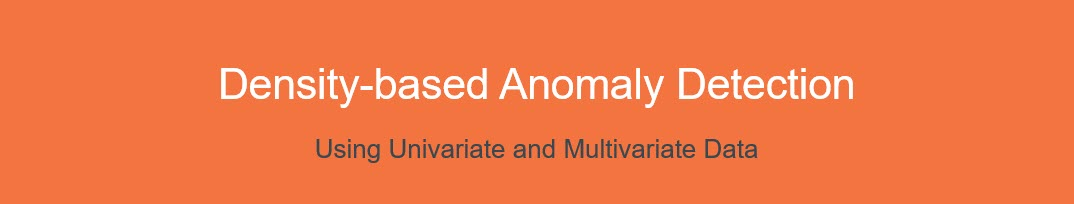

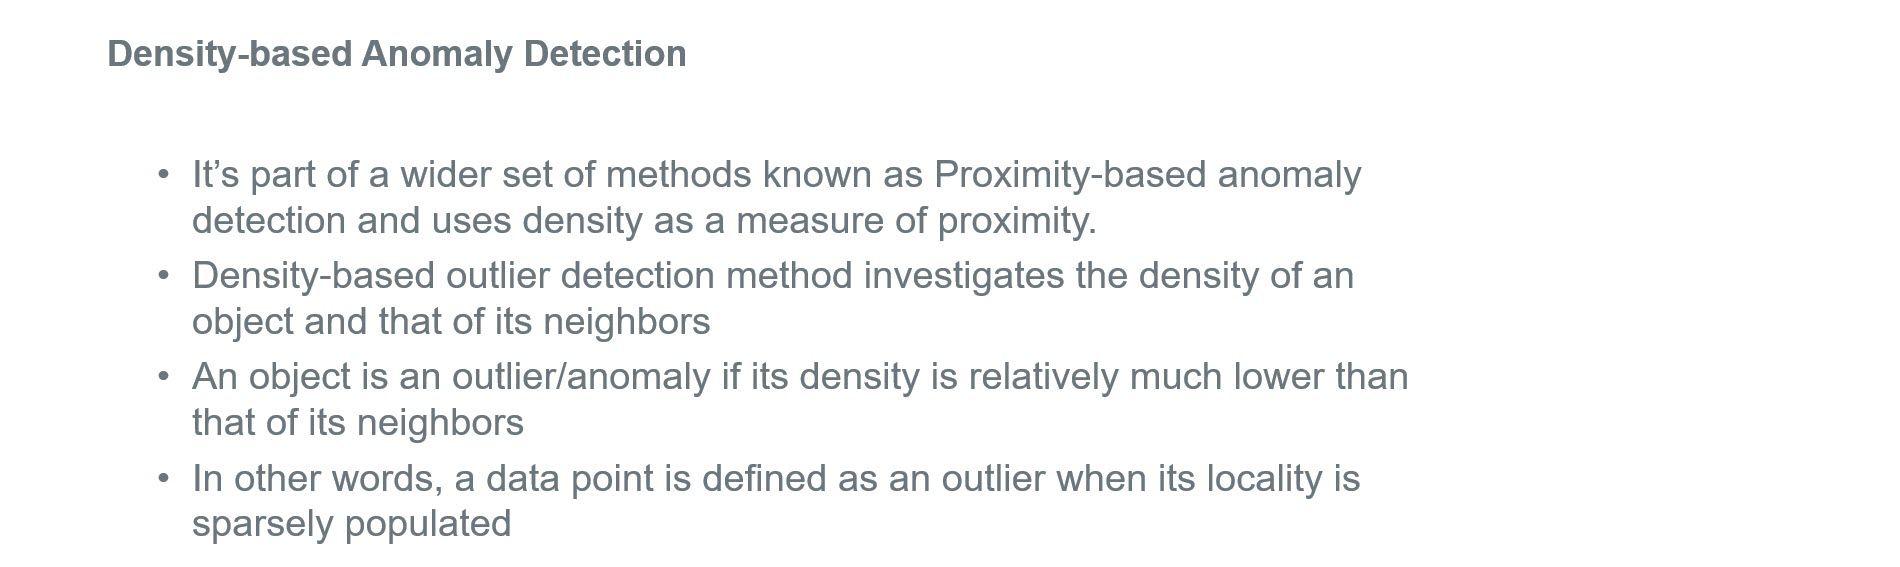

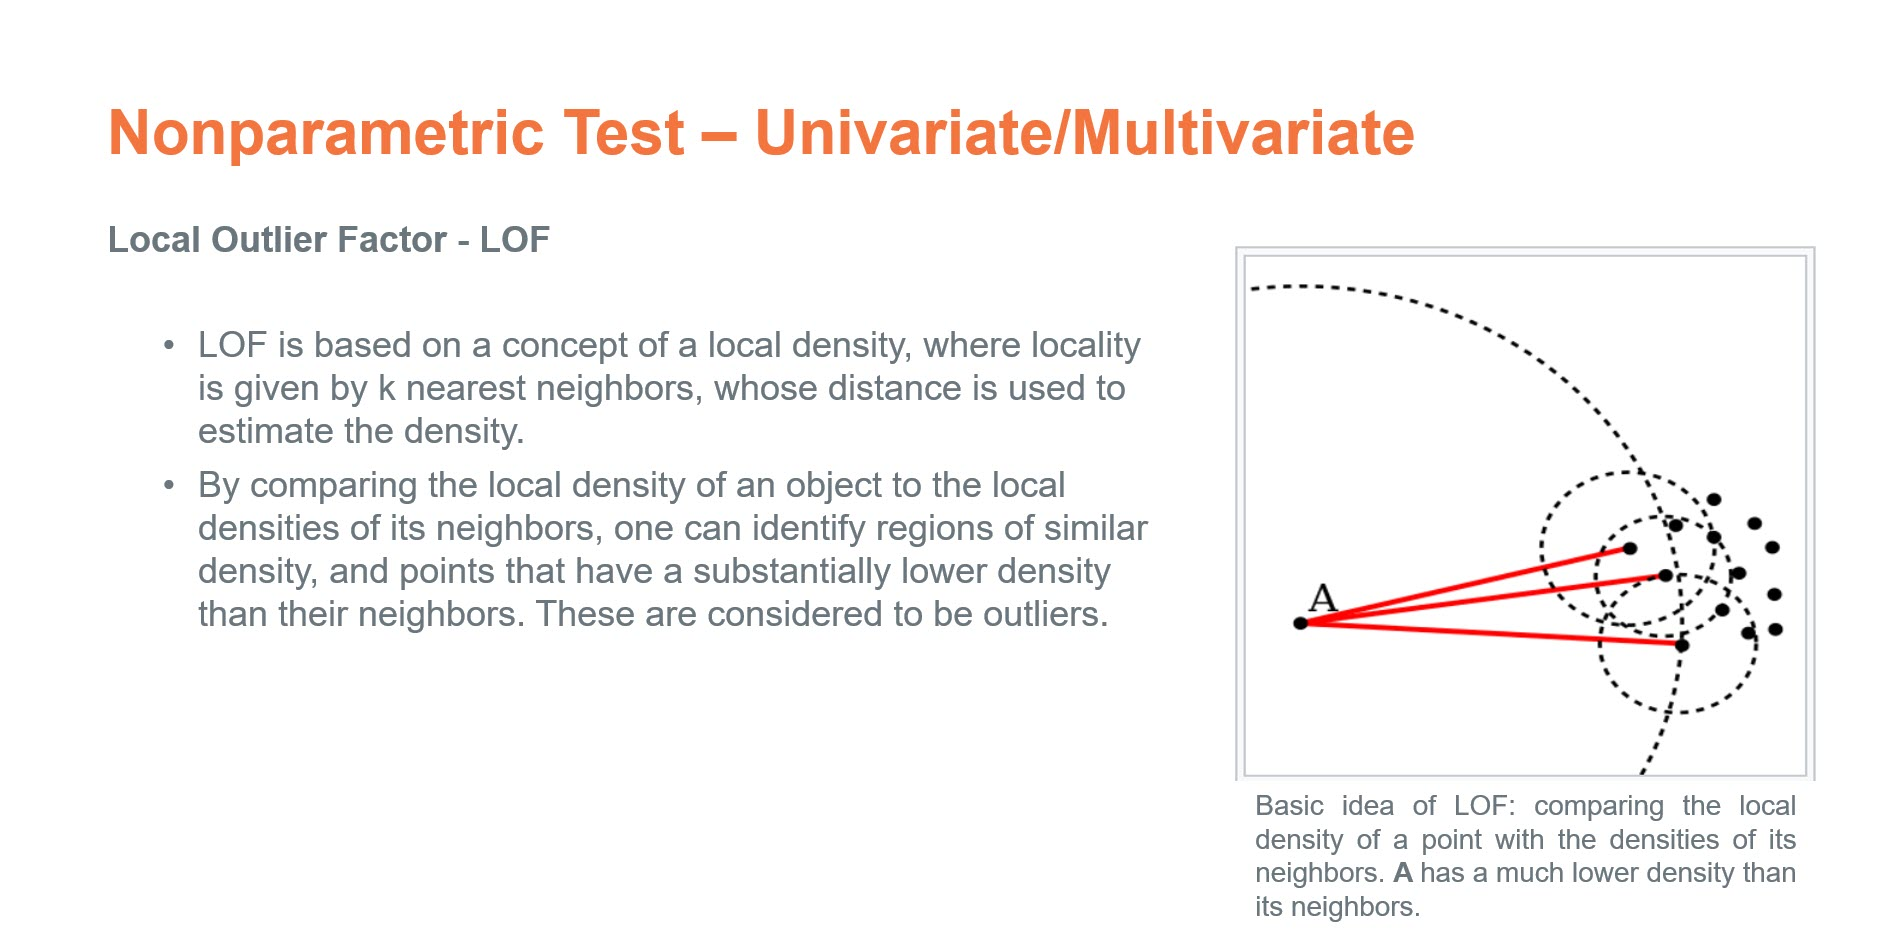

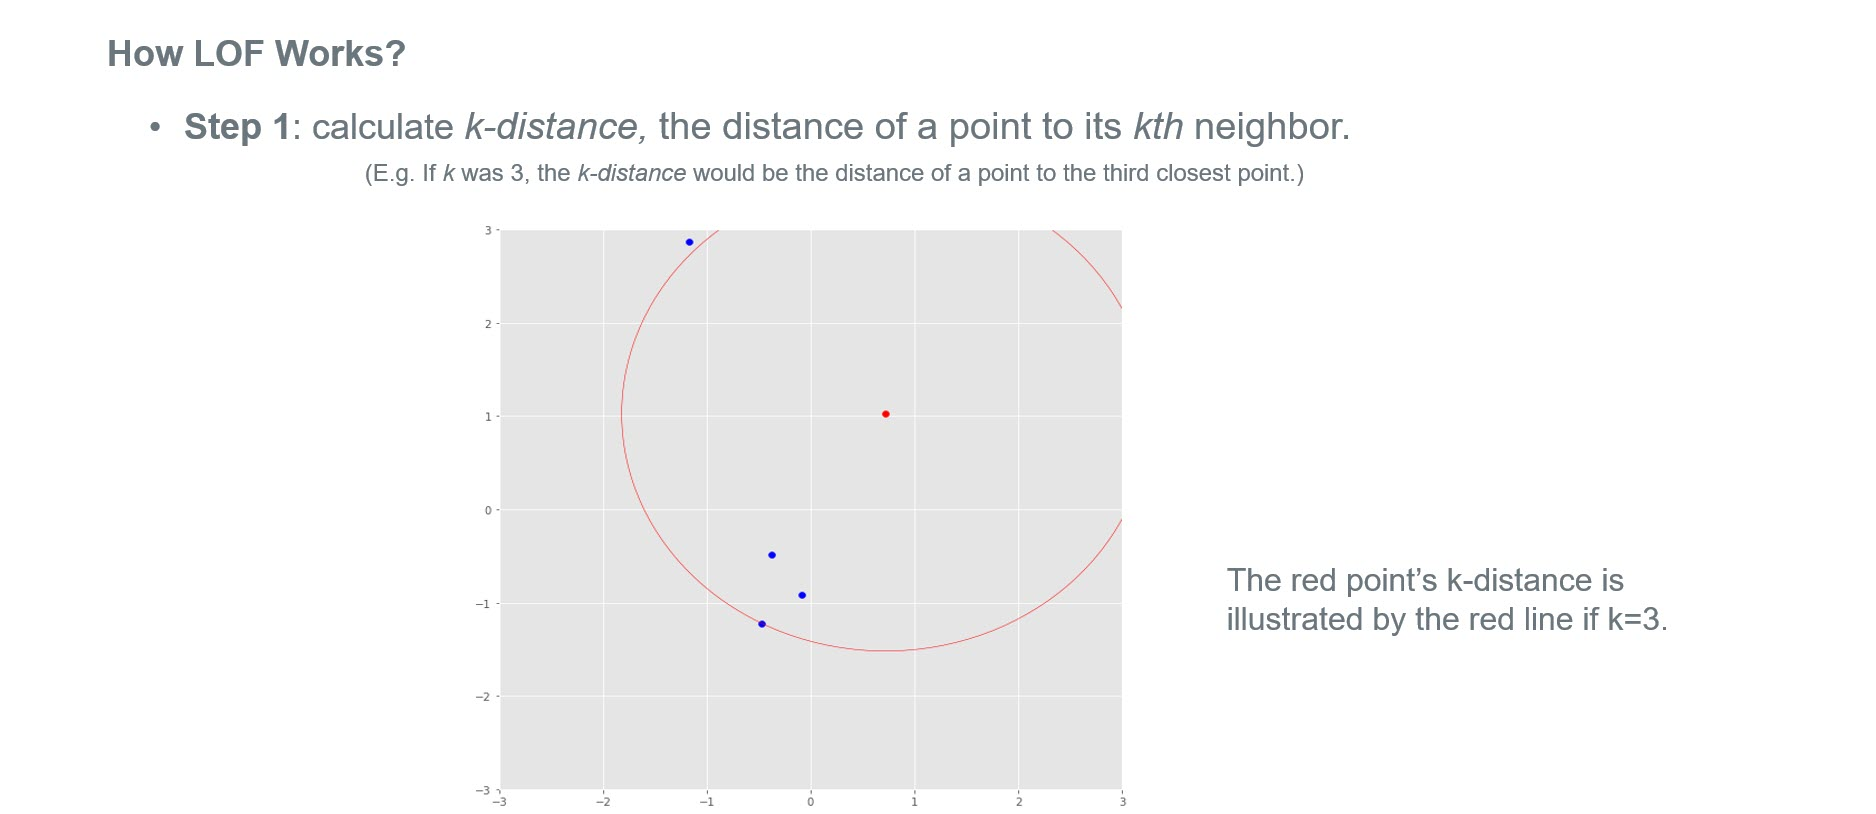

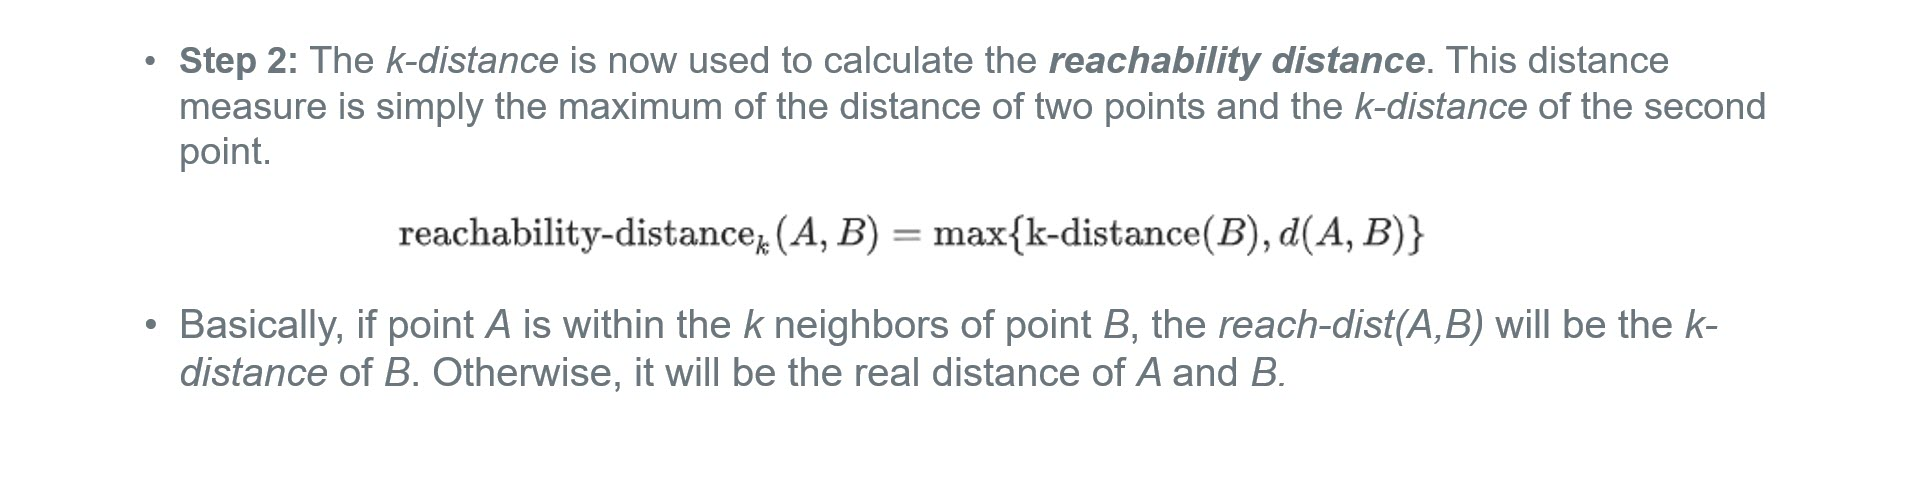

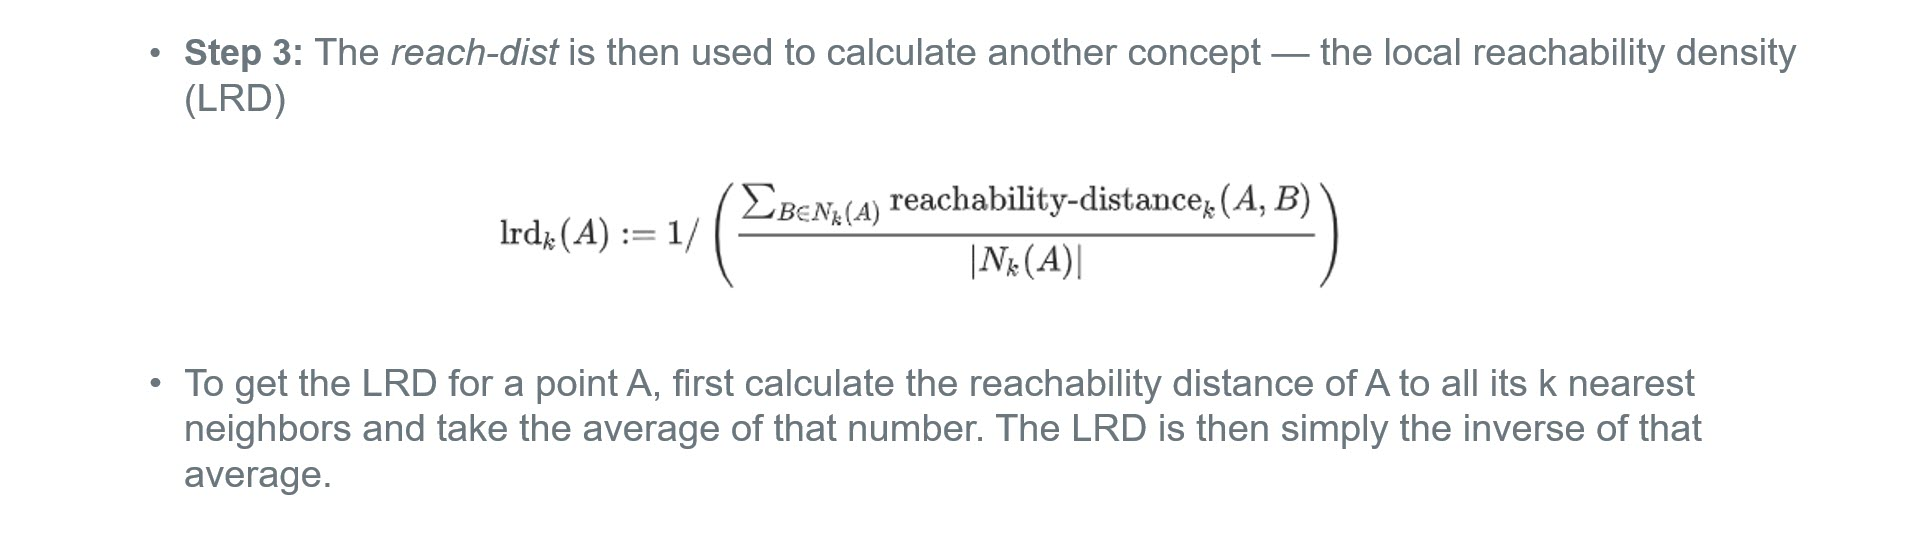

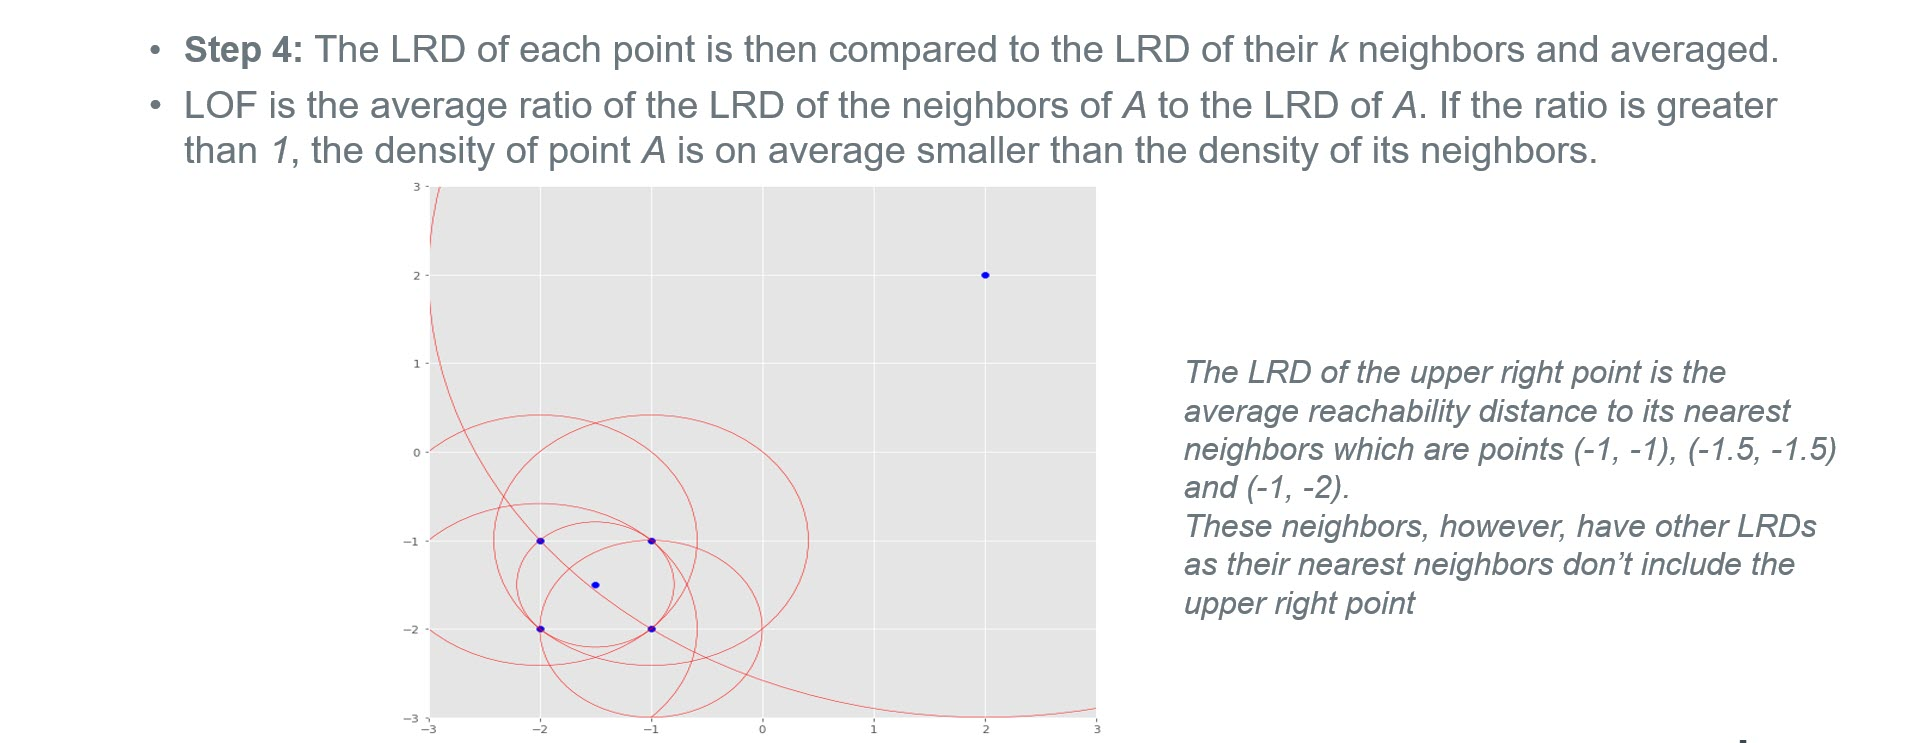

### Local Outlier Factor (LOF) Implementation

In [39]:
df = pdMultiData
LOF_multi_df=pd.DataFrame(columns=['FR', 'FL','RR','RL'], data=df.values, index=df.index)
columns=LOF_multi_df.columns
LOF = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
pred_outliers=LOF.fit_predict(LOF_multi_df[columns])
X_scores = LOF.negative_outlier_factor_
#print(X_scores)
LOF_multi_df['outlier_score'] = X_scores
LOF_multi_df['outliers'] = pred_outliers
LOF_multi_df[LOF_multi_df.outliers == -1]
#col=LOF_multi_df.columns
#LOF_multi_df[col]

FR        FL        RR        RL  \
2016-04-20 06:29:22.100  0.525000  0.525000  0.000000  0.675000   
2016-04-20 06:29:23.600 -0.100000  0.000000  0.000000  0.000000   
2016-04-20 06:29:23.700 -0.025000  0.000000 -0.175000  0.000000   
2016-04-20 06:29:23.800  0.175000  0.000000  0.050000  0.000000   
2016-04-20 06:29:27.800  0.000000  0.000000 -0.025000 -0.100000   
2016-04-20 06:29:27.900  0.000000  0.175000  0.000000  0.000000   
2016-04-20 06:29:29.500  0.075000  0.000000  0.050000  0.000000   
2016-04-20 06:29:31.000  0.100000  0.075000  0.000000 -0.075000   
2016-04-20 06:29:31.100  0.000000 -0.025000  0.000000  0.225000   
2016-04-20 06:29:31.200  0.000000 -0.050000  0.000000 -0.150000   
2016-04-20 06:29:31.300  0.000000  0.000000  0.000000 -0.075000   
2016-04-20 06:29:31.400  0.000000  0.125000  0.000000  0.000000   
2016-04-20 06:29:31.500  0.000000 -0.125000  0.125000  0.025000   
2016-04-20 06:29:31.700  0.000000  0.150000 -0.150000  0.000000   
2016-04-20 06:29:31.800  0.000000  0.000000  0.225000  0.000000   
2016-04-20 06:29:31.900  0.000000 -0.125000  0.000000  0.000000   
2016-04-20 06:29:32.000  0.000000  0.125000 -0.025000  0.000000   
2016-04-20 06:29:32.200  0.000000 -0.075000  0.000000 -0.050000   
2016-04-20 06:29:32.300 -0.075000  0.075000  0.000000 -0.150000   
2016-04-20 06:29:32.600  0.000000 -0.100000 -0.025000 -0.100000   
2016-04-20 06:29:33.100 -0.175000  0.000000 -0.025000  0.000000   
2016-04-20 06:29:33.300  0.175000  0.000000  0.050000  0.000000   
2016-04-20 06:29:36.300 -1.200000  0.000000 -3.600000 -3.375000   
2016-04-20 06:29:36.400 -2.625000 -7.175000  0.000000  0.000000   
2016-04-20 06:29:36.500 -6.125000 -3.075000 -6.400000 -6.400000   
2016-04-20 06:29:36.600  0.000000  0.000000 -1.600000 -1.600000   
2016-04-20 06:29:38.300  1.125000  0.000000  0.000000  0.000000   
2016-04-20 06:29:38.400  1.425000  0.000000  0.000000  0.000000   
2016-04-20 06:29:38.500  1.600000  1.925000  2.100000  0.000000   
2016-04-20 06:29:43.500  4.225000  3.250000  3.750000  2.375000   
...                           ...       ...       ...       ...   
2016-04-20 06:36:35.600  1.700000  2.625000  4.050000  1.775000   
2016-04-20 06:36:35.700  2.850000  1.650000 -0.300000  1.600000   
2016-04-20 06:36:35.800  1.650000  2.575000  2.900000  2.150000   
2016-04-20 06:36:36.700  3.375000  1.900000  0.700000  2.750000   
2016-04-20 06:36:37.500  1.750000  2.475000  3.275000  1.825000   
2016-04-20 06:36:37.600  3.525000  1.950000  1.600000  2.400000   
2016-04-20 06:36:37.700  2.000000  2.800000  3.800000  2.275000   
2016-04-20 06:36:38.300  2.150000  0.325000 -0.250000  1.250000   
2016-04-20 06:36:38.400 -1.175000  1.125000  1.825000  0.500000   
2016-04-20 06:36:38.500  1.550000  0.775000  2.725000  0.200000   
2016-04-20 06:36:38.600  1.050000 -0.050000 -3.400000 -0.400000   
2016-04-20 06:36:38.700 -0.825000  0.375000  3.125000  2.750000   
2016-04-20 06:36:38.900  0.350000  0.675000  0.825000 -0.100000   
2016-04-20 06:36:39.000  0.275000 -0.225000 -0.050000  0.300000   
2016-04-20 06:36:40.100 -0.400000  0.100000 -0.250000 -0.325000   
2016-04-20 06:36:41.300 -2.500000 -1.875000 -1.700000 -3.050000   
2016-04-20 06:36:41.400 -2.550000 -3.025000 -3.550000 -2.225000   
2016-04-20 06:36:42.000 -1.581818 -0.934091 -0.475000 -0.945455   
2016-04-20 06:36:42.100 -0.373737 -1.174242 -1.750000 -0.815657   
2016-04-20 06:36:42.400 -1.416667 -0.502525 -0.242424 -1.429293   
2016-04-20 06:36:42.700 -0.538636 -1.102273 -1.029545 -0.620455   
2016-04-20 06:36:46.400 -6.025000 -4.150000 -4.000000 -3.800000   
2016-04-20 06:36:46.500 -2.850000 -4.375000 -4.125000 -5.075000   
2016-04-20 06:36:46.700 -5.750000 -5.150000 -4.200000 -5.175000   
2016-04-20 06:36:46.800 -5.225000 -5.575000 -7.925000 -5.775000   
2016-04-20 06:36:46.900 -5.375000 -5.425000 -3.950000 -4.775000   
2016-04-20 06:36:47.000 -5.525000 -4.850000 -4.075000 -4.925000   
2016-04-20 06:36:52.500 -0.500000 -1.375000 -1.500000 -2.450000   
2016-04-20 

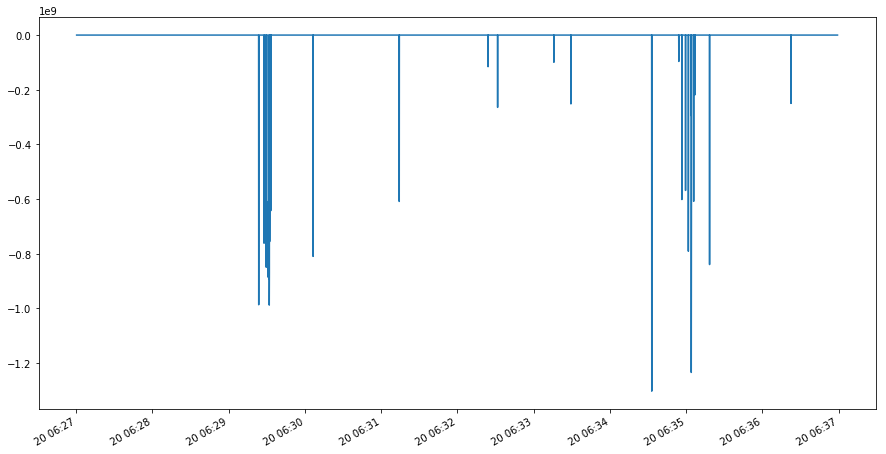

In [60]:
LOF_multi_df['outlier_score'].plot(figsize=(15,8))

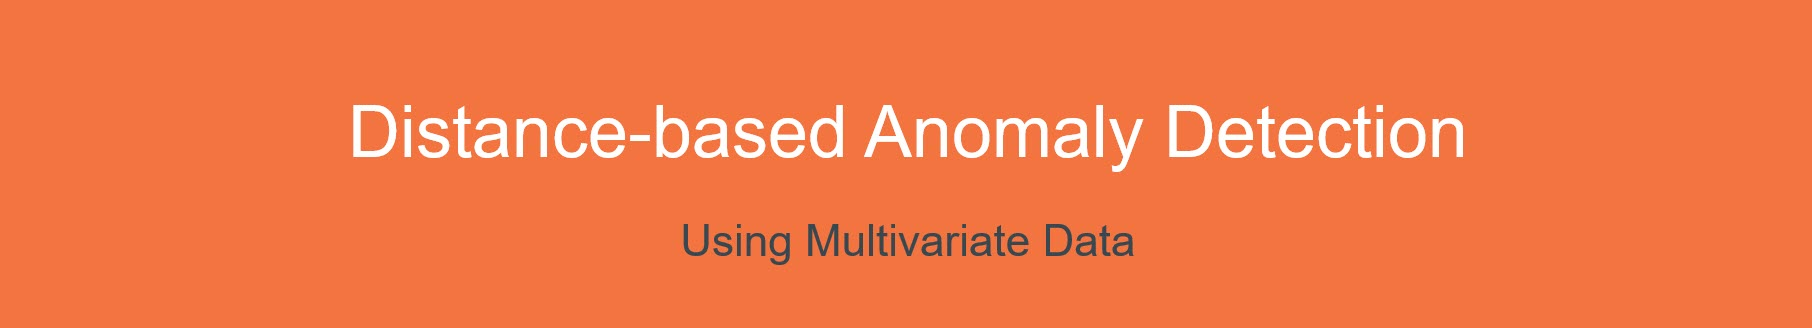

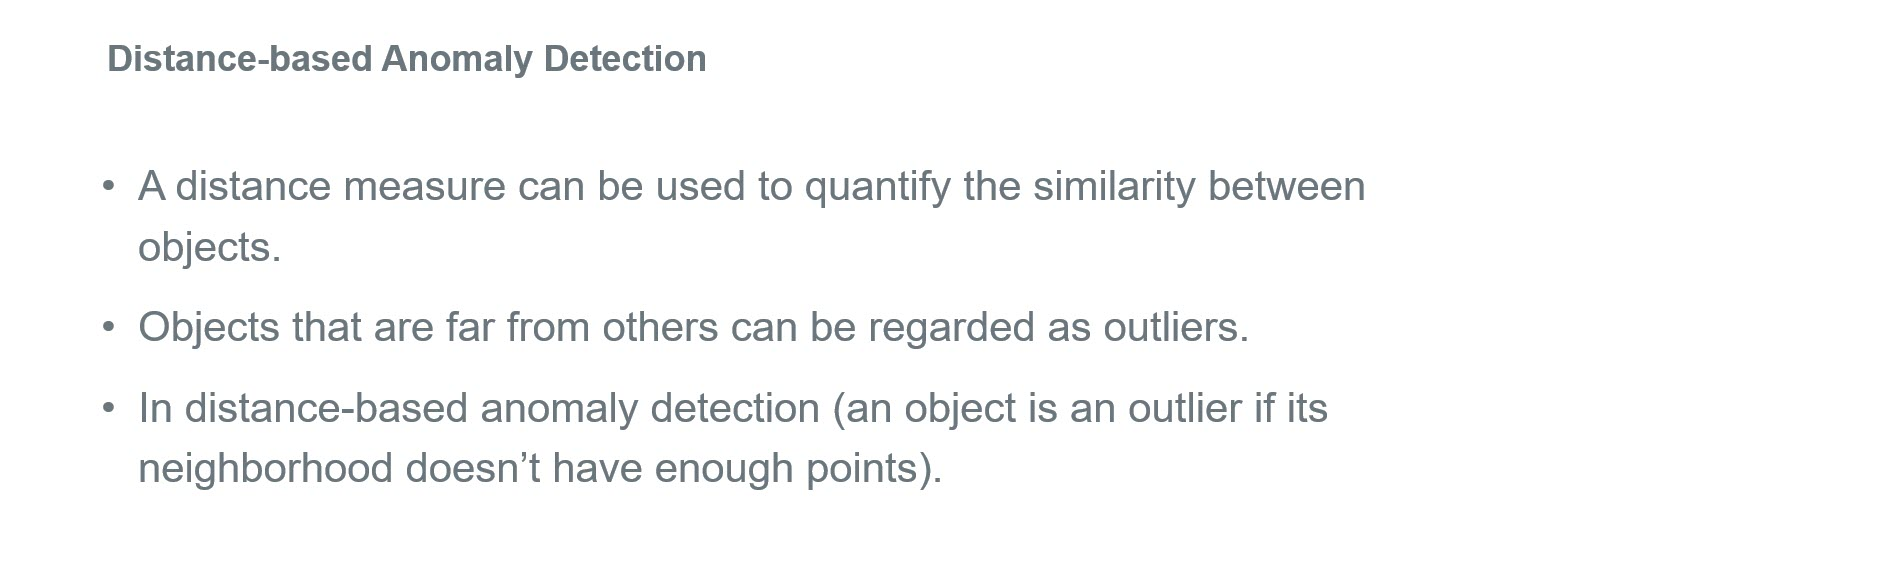

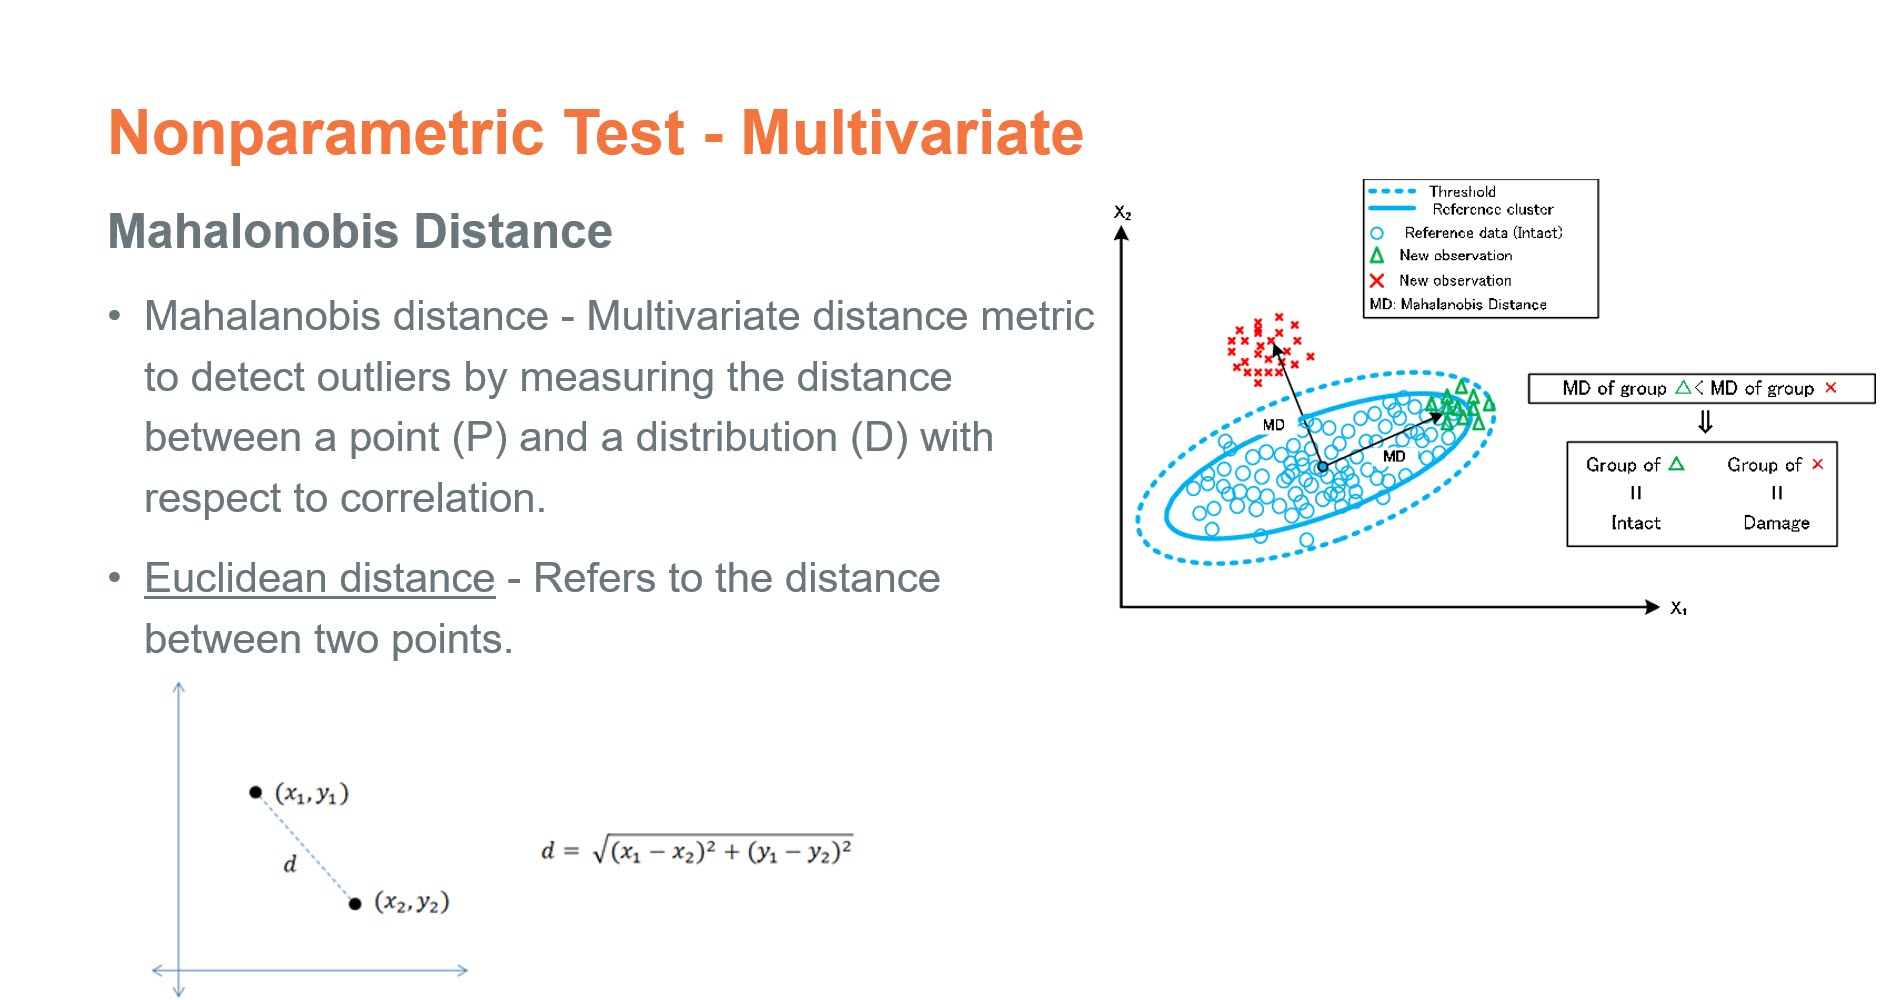

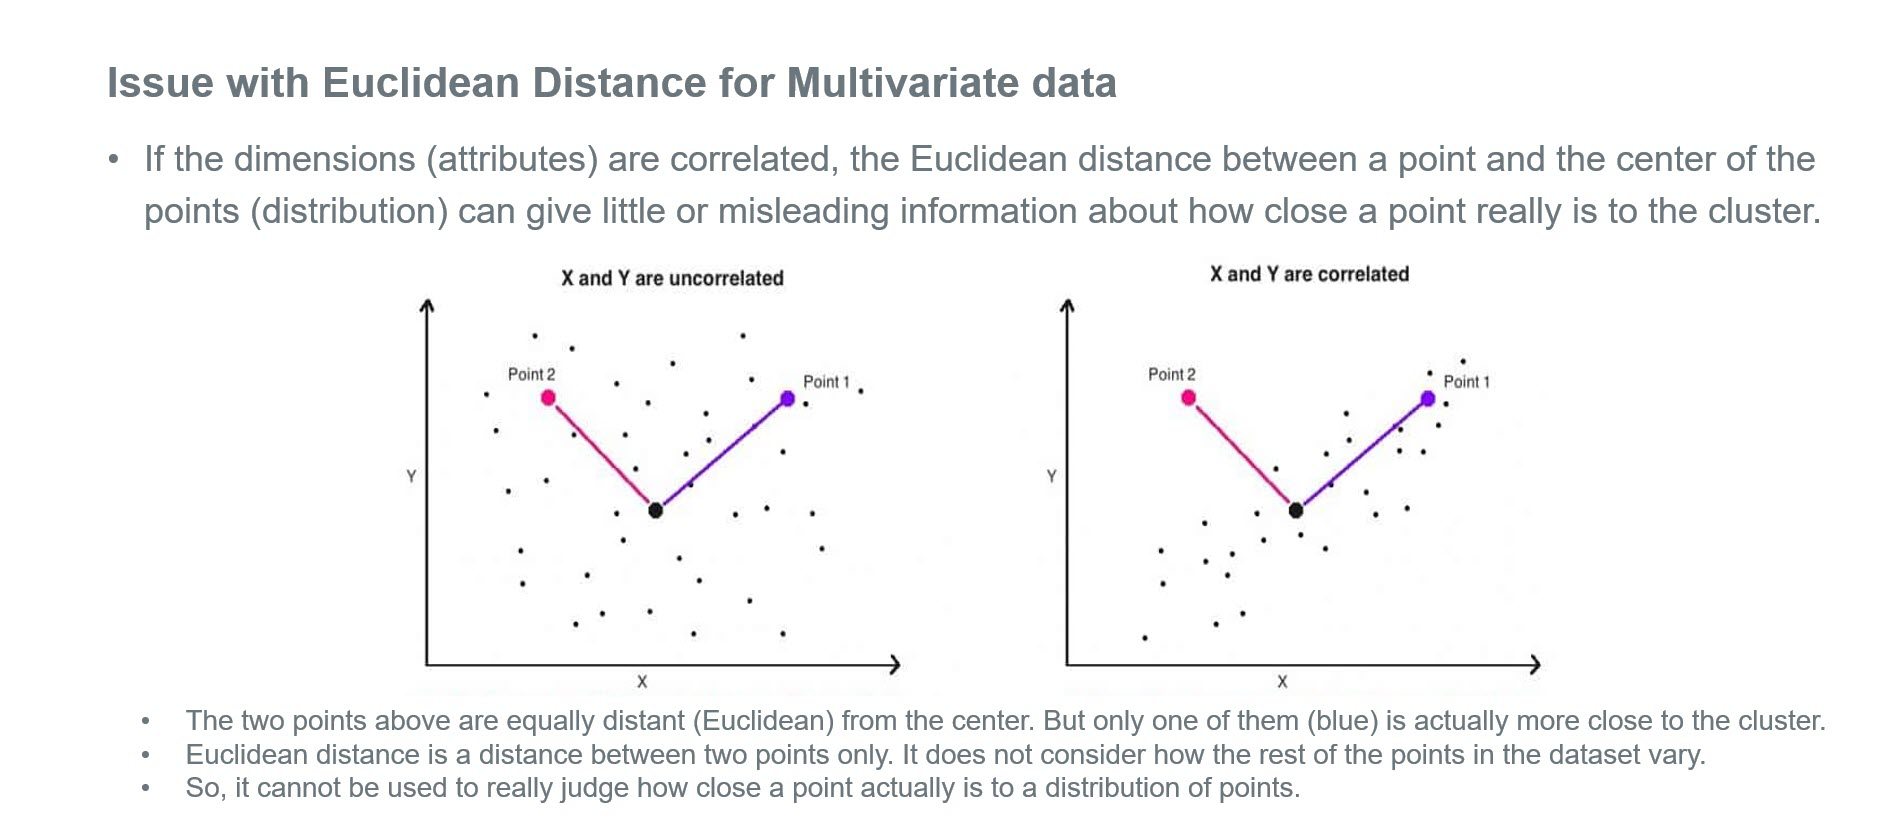

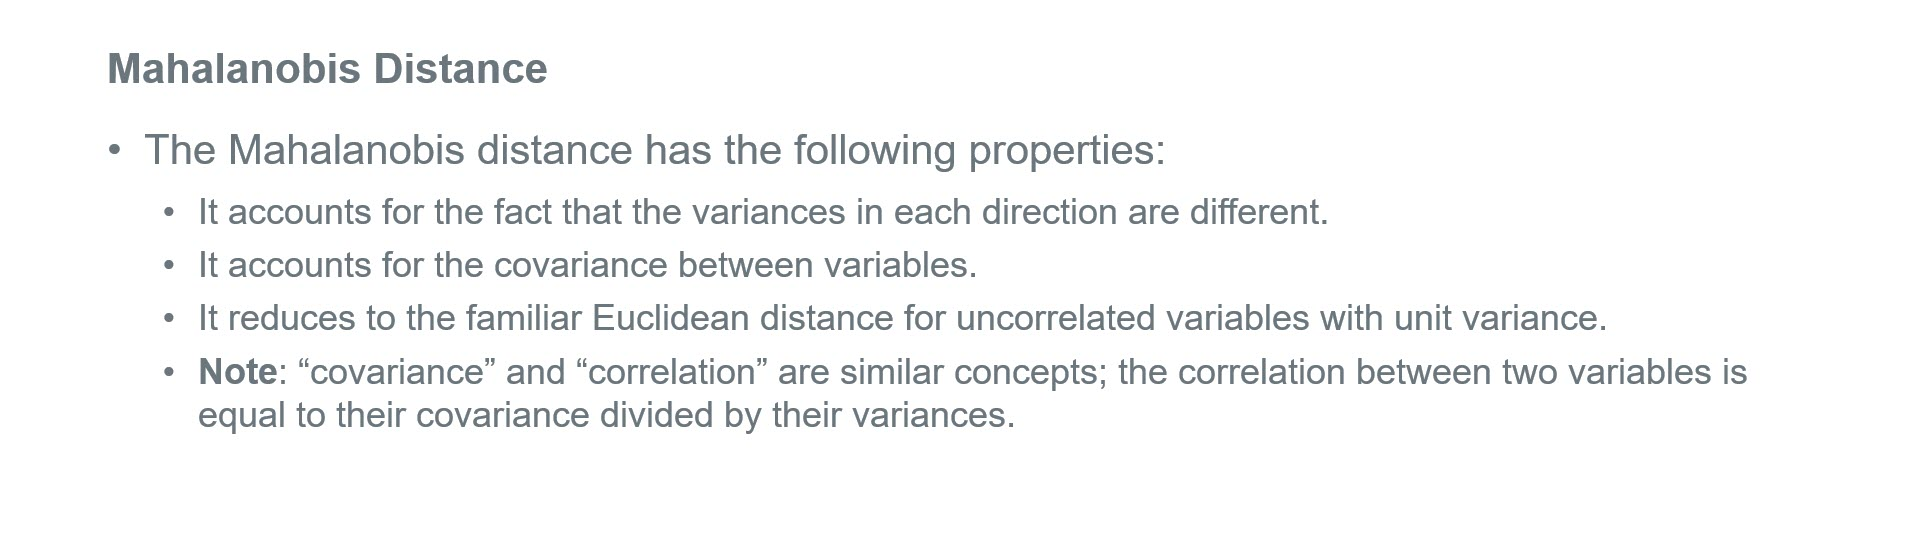

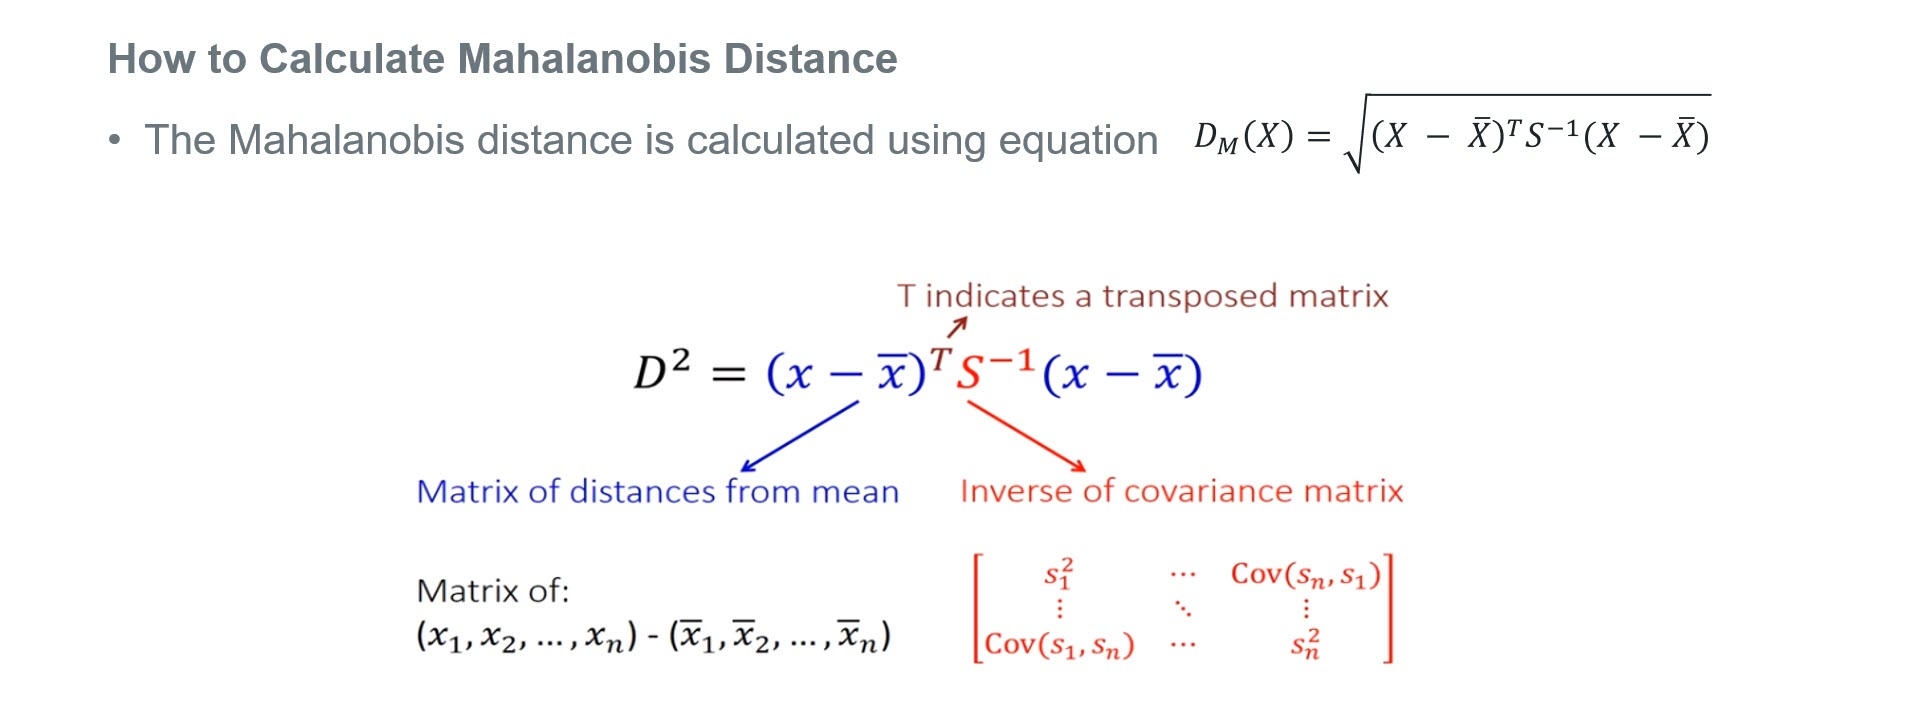

### Implementation
### Calculate P-Values using Mahalanobis Distance 
- calculate mu/sigma from the wheel sensor data
- calculate probabilities using Chi-squared distribution
- distance and p-values (for that distance) are joined in existing dataframe with the corresponding points
- save results in a csv

In [103]:
n, k, pd_data_mean, S = calc_mu_sigma(pdMultiData[['FR', 'FL', 'RR', 'RL']])

In [41]:
md_prob = [calc_p_md([pdMultiData['FR'].iloc[idx], pdMultiData['FL'].iloc[idx], pdMultiData['RR'].iloc[idx], pdMultiData['RL'].iloc[idx]], n, k, pd_data_mean, S) for idx in range(pdMultiData.shape[0])]
md_prob = np.array(md_prob)

pd_outliers = pd.DataFrame({'distance':md_prob[:,0],'p-value':md_prob[:,1]})
pd_outliers.index = pdMultiData.index
# df_pvalues.to_csv(data_dir + data_output_file, index = False)

# pd_outliers = pd_outliers[pd_outliers['p-value'] < 0.05].dropna()
pd_outliers['outlier'] = np.where(pd_outliers['p-value'] < 0.05, 1, 0)
# pd_outliers
pd_outliers = pd_outliers.join(pdMultiData)
pd_outliers = pd_outliers.join(data_sampled[['Steering_Wheel_Absolute_Angle', 'Acceleration_Sensor_Value', 'Yaw_Rate', 'Lateral_Sensor_Value', 'Vehicle_Speed']])

pd_outliers.sort_values(['distance', 'p-value'], ascending = False).to_csv("../outliers_md.csv")


In [42]:
pd_outliers = pd_outliers[pd_outliers.outlier == 1]

### Outlier Plot

This section plots outliers as vertical lines for different sensor readings.

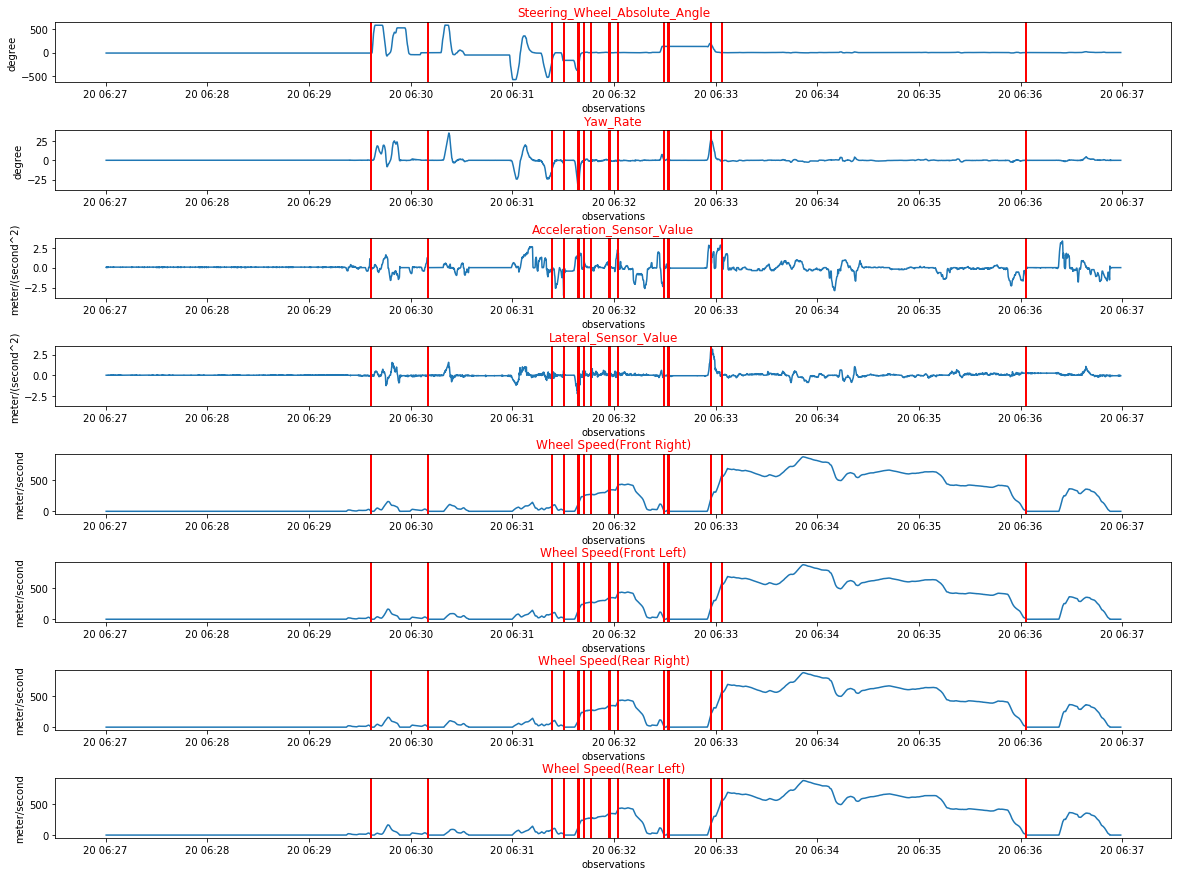

In [43]:
unit_dict = {
    'Steering_Wheel_Absolute_Angle':'degree',
             'Yaw_Rate':'degree',             
             'Acceleration_Sensor_Value':'meter/(second^2)',
             'Lateral_Sensor_Value': 'meter/(second^2)', 
    'Steering_Wheel_Absolute_Angle':'degree',
            'Wheel Speed(Front Right)':'meter/second',
            'Wheel Speed(Front Left)':'meter/second',
            'Wheel Speed(Rear Right)':'meter/second',
            'Wheel Speed(Rear Left)':'meter/second'}
fig,ax = plt.subplots(len(unit_dict),1,figsize = (20,15))
plt.subplots_adjust(hspace = 0.8)

ip = 1-pd_outliers['p-value']
pd_outliers['vline_size'] = (ip - min(ip))/(max(ip) - min(ip))

i = 0 
for key,val in unit_dict.items():
#     print(data_sampled.index)
    ax[i].plot(data_sampled[key])

    for xc in pd_outliers.index:
        ax[i].axvline(x=xc, color='r', linestyle='-', linewidth=2)
        
    ax[i].set_title(key,color = 'red')
    ax[i].set_ylabel(val)
    ax[i].set_xlabel('observations')
    i = i+1

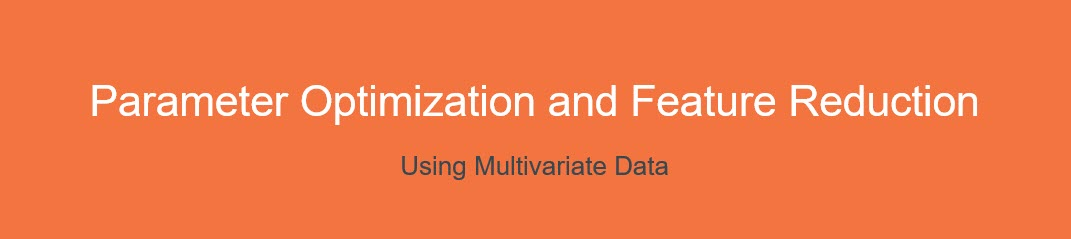

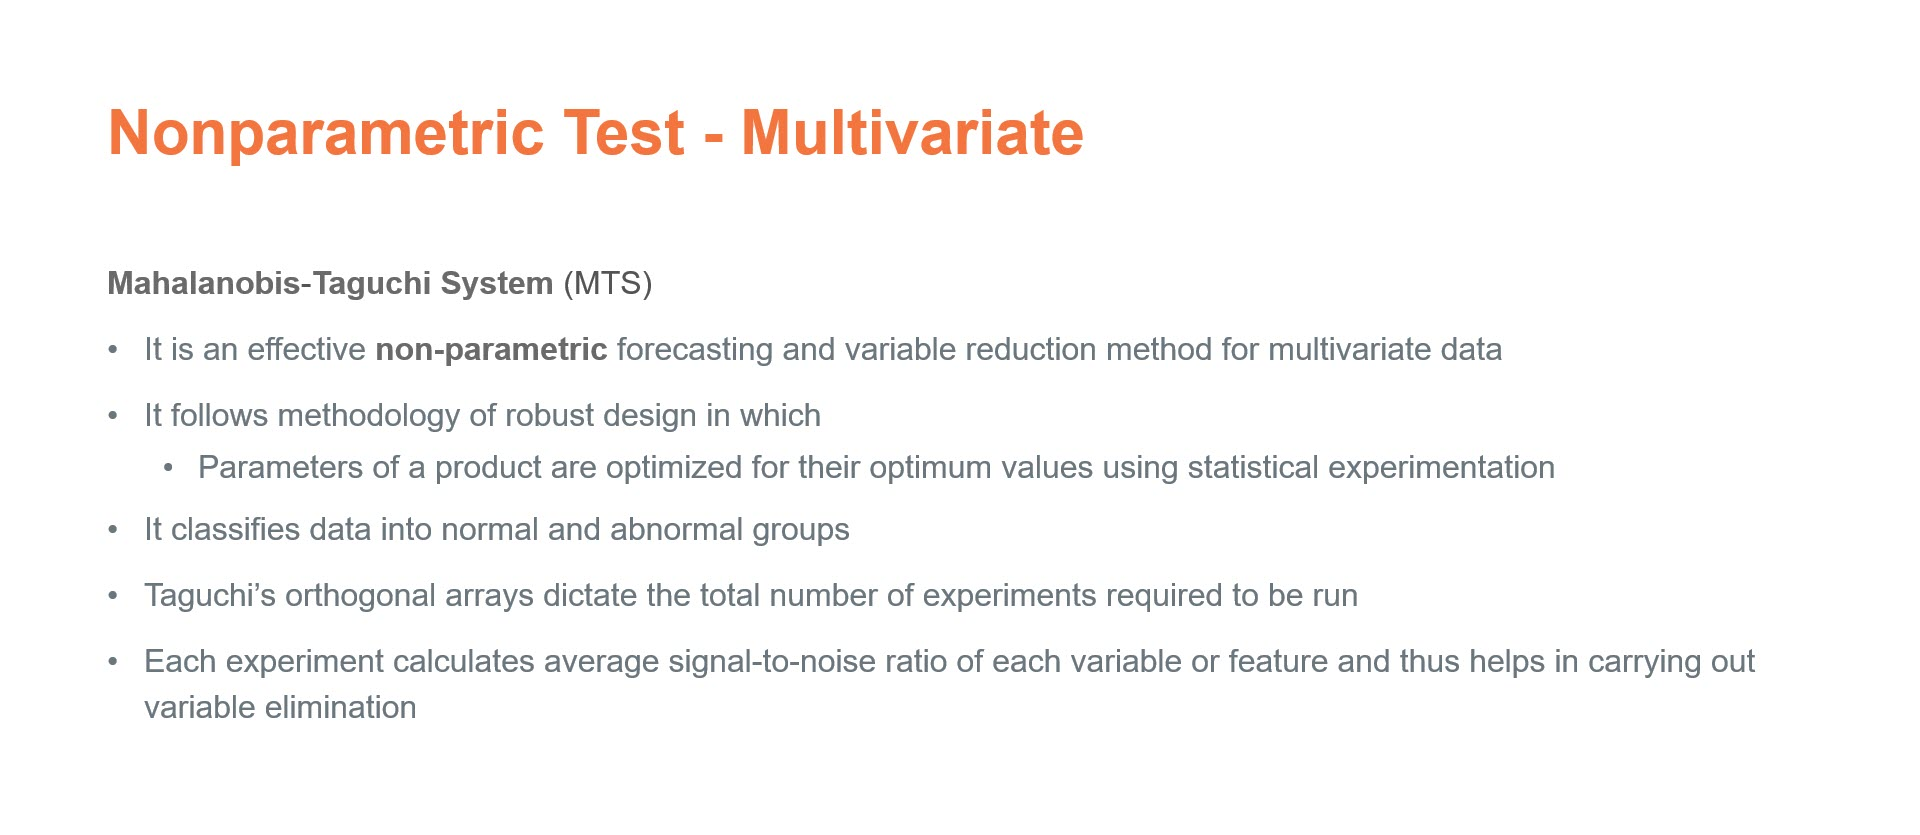

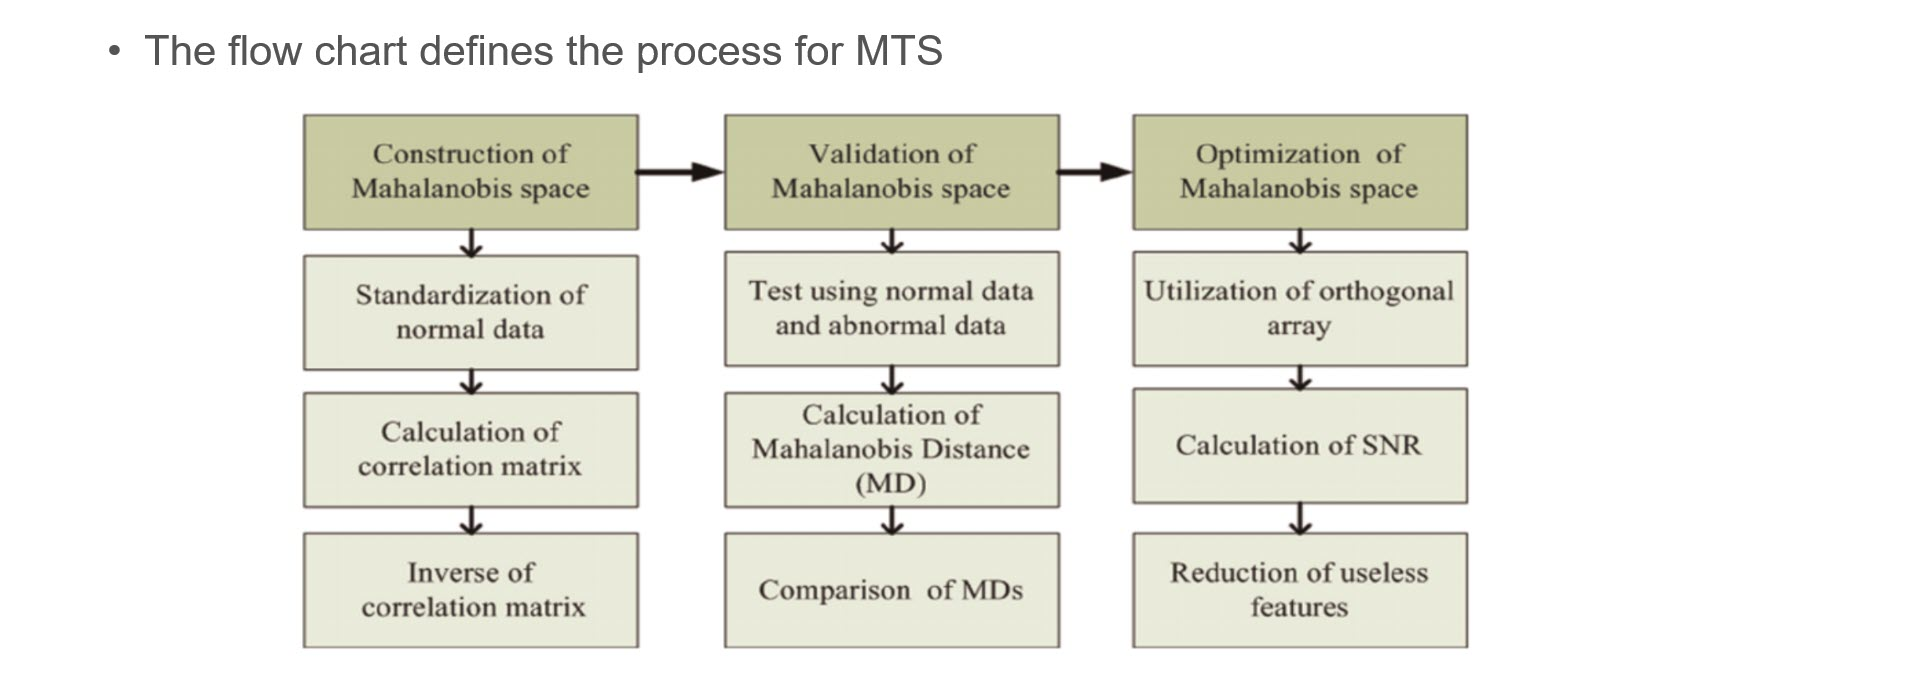

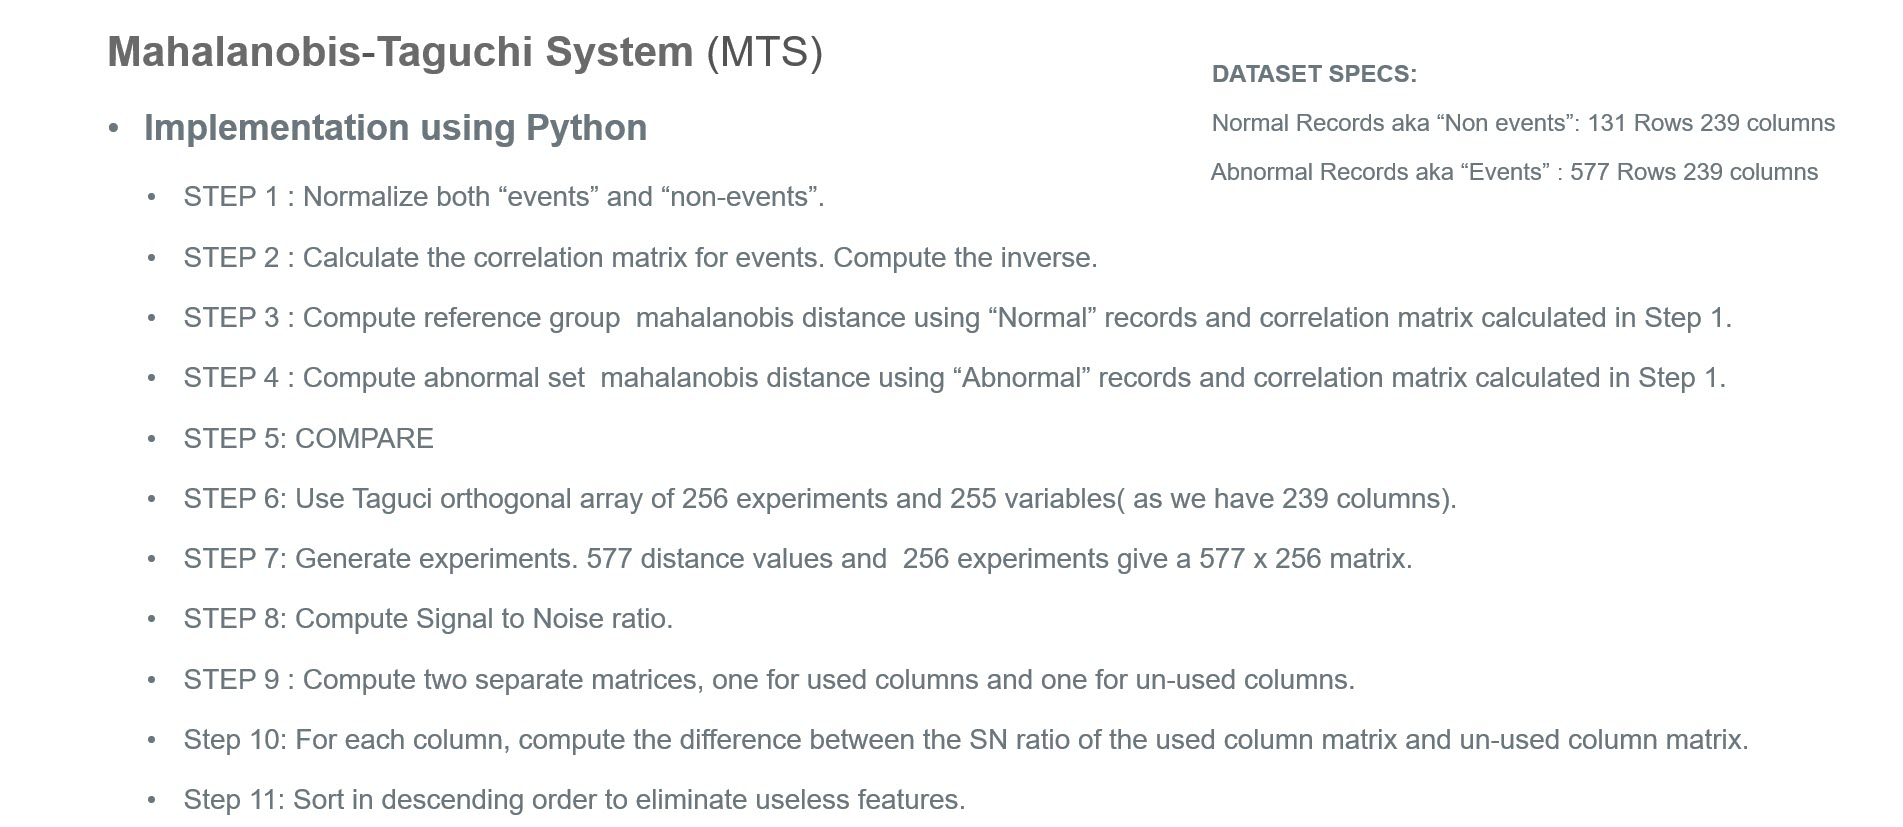

### Implementation
### Mahalanobis Taguci System (MTS)
Following code implements Taguci method with Mahalanobis distance

In [44]:
mts_normal = pdMultiData.reset_index()
mts_normal.rename(columns = {'index':'timestamp'}, inplace = True)
mts_normal = mts_normal[['FR', 'FL', 'RR', 'RL']]

In [45]:
orthoarray_filename = "..\Suzuki\L8.csv"
ortho_array = pd.read_csv(orthoarray_filename, header = None)

n, k, pd_data_mean, S = calc_mu_sigma(mts_normal)
# ref_group = [distance.mahalanobis(list(mts_normal.iloc[idx]), pd_data_mean, S) for idx in range(mts_normal.shape[0])]

### Taguci Array
- Mahalanobis Distance
- Signal to Noise Ratio
- Orthogonal Array and Matrix

In [46]:
################ TAGUCHI ARRAY ################
# make an orthogonal array

nVariables = mts_normal.shape[1]
ortho_arr = ortho_array.iloc[:, :nVariables]
nCols = list(range(0, len(ortho_arr.columns)))
var_names = list(mts_normal.columns)
bool_val = (ortho_arr == 1)

runs = bool_val.apply(cal_md, axis = 1).transpose()

sn_ratio = sn_ratio(runs)

#### Optimal Combination Inclusion vs Exclusion
- Calculate distances for different datasets
- Apply signal to noise ratio

In [47]:
ortho_arr_cpy = copy.deepcopy(ortho_arr)
ortho_arr_cpy[ortho_arr_cpy==2] = 0
nCol = ortho_arr_cpy.shape[1]
sn_ratio_rep = pd.concat([sn_ratio] * nCol, axis=1)
result = (sn_ratio_rep * ortho_arr_cpy)
mat_used_cols = result.mean(axis = 0)
ortho_arr_cpy = copy.deepcopy(ortho_arr)

ortho_arr_cpy[ortho_arr_cpy==1] = 0
ortho_arr_cpy[ortho_arr_cpy==2] = 1
nCol = ortho_arr_cpy.shape[1]
sn_ratio_rep = pd.concat([sn_ratio] * nCol, axis=1)
result = (sn_ratio_rep * ortho_arr_cpy)
mat_notused_cols = result.mean(axis = 0)

### Differences
- compute difference for a variable when it was included/excluded
- Signal to Noise Ratio - bigger the better

In [48]:
avr_sn_ratio = pd.DataFrame(dict(mat_used_cols = mat_used_cols, mat_notused_cols = mat_notused_cols))
avr_sn_ratio['diff'] = avr_sn_ratio['mat_used_cols'] - avr_sn_ratio['mat_notused_cols']
avr_sn_ratio['var_names'] = np.array(var_names)
avr_sn_ratio.set_index('var_names', inplace = True)
ordered_ratio = avr_sn_ratio.sort_values(by=['diff'], ascending=False)

### Sample Dataset for Top 2 Variables

In [49]:
nvars = 2
new_normal = mts_normal[np.array(ordered_ratio.iloc[:nvars, :].index)]
col_comb = new_normal.columns

### Test Mahalanobis Distance on New Dataset

In [50]:
n, k, pd_data_mean, S = calc_mu_sigma(new_normal[list(col_comb)])
md_prob = [calc_p_md([new_normal['FR'].iloc[idx], new_normal['FL'].iloc[idx]], n, k, pd_data_mean, S) for idx in range(new_normal.shape[0])]
md_prob = np.array(md_prob)

pd_outliers = pd.DataFrame({'distance':md_prob[:,0],'p-value':md_prob[:,1]})
pd_outliers.index = new_normal.index
pd_outliers['outlier'] = np.where(pd_outliers['p-value'] < 0.05, 1, 0)

# pd_outliers
pd_outliers = pd_outliers.join(new_normal)
# pd_outliers = pd_outliers.join(data_sampled[['Steering_Wheel_Absolute_Angle', 'Acceleration_Sensor_Value', 'Yaw_Rate', 'Lateral_Sensor_Value', 'Vehicle_Speed']])

# pd_outliers.sort_values(['distance', 'p-value'], ascending = False).to_csv("../data/processed/outliers_md.csv")

In [51]:
pd_outliers[pd_outliers.outlier == 1]

distance   p-value  outlier      FR      FL
1555  10.158996  0.006223        1  -2.625  -7.175
1556   6.898813  0.031764        1  -6.125  -3.075
1644   6.900793  0.031733        1   2.450   5.500
1645   6.693060  0.035206        1   2.850   5.775
1727   6.733121  0.034508        1  -4.750  -1.700
1892   8.879018  0.011802        1  -2.325  -6.300
1893   6.157017  0.046028        1  -5.425  -2.700
2696   6.344857  0.041902        1 -13.000 -11.925
2785   7.569982  0.022709        1   6.675   3.325
2786   8.029184  0.018050        1   7.125   3.575
2787   7.225505  0.026977        1   8.050   5.000
2789   7.538105  0.023074        1   8.225   5.025
2790   6.119587  0.046897        1   7.725   5.250
3013   6.582468  0.037208        1   8.400   5.750
3014   8.366229  0.015251        1   4.850   8.400
3288  11.931434  0.002565        1  -9.000  -3.625
3289   7.900141  0.019253        1   0.000  -3.625
3555   6.210642  0.044810        1  10.725   8.775
3564   7.644927  0.021874        1   6.100   2.675
5423   7.409787  0.024603        1   0.000  -3.400
5917   6.464128  0.039476        1  -4.625  -1.700

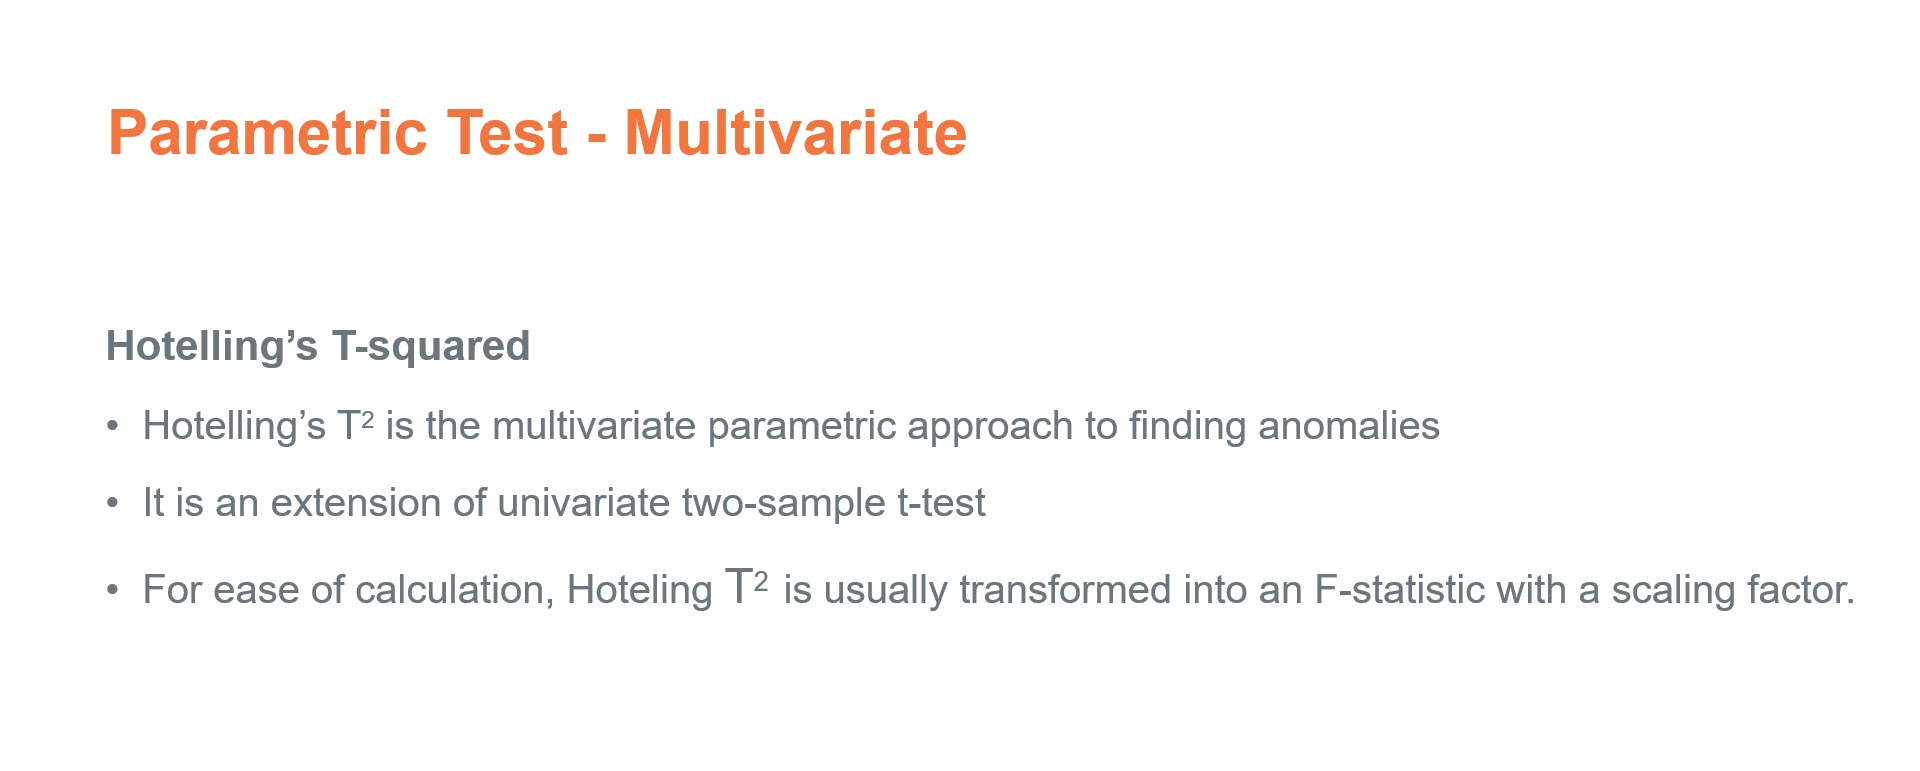

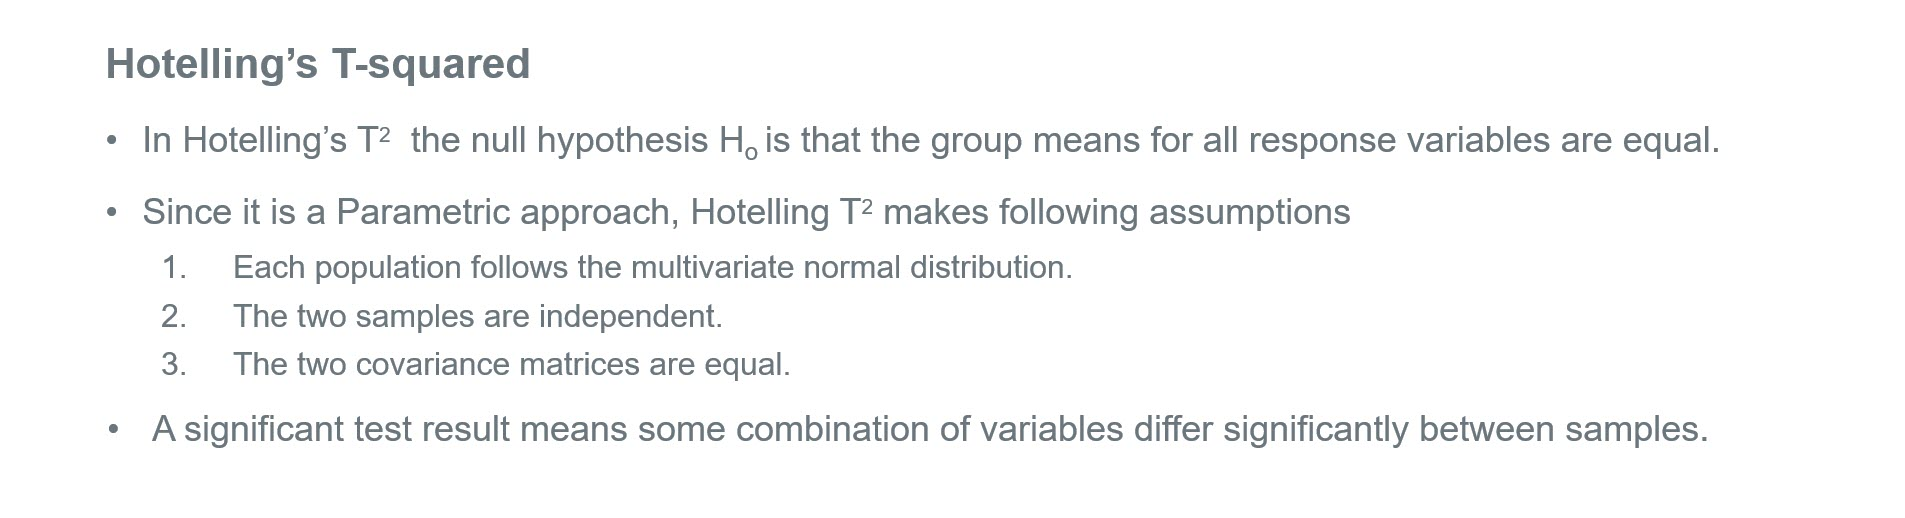

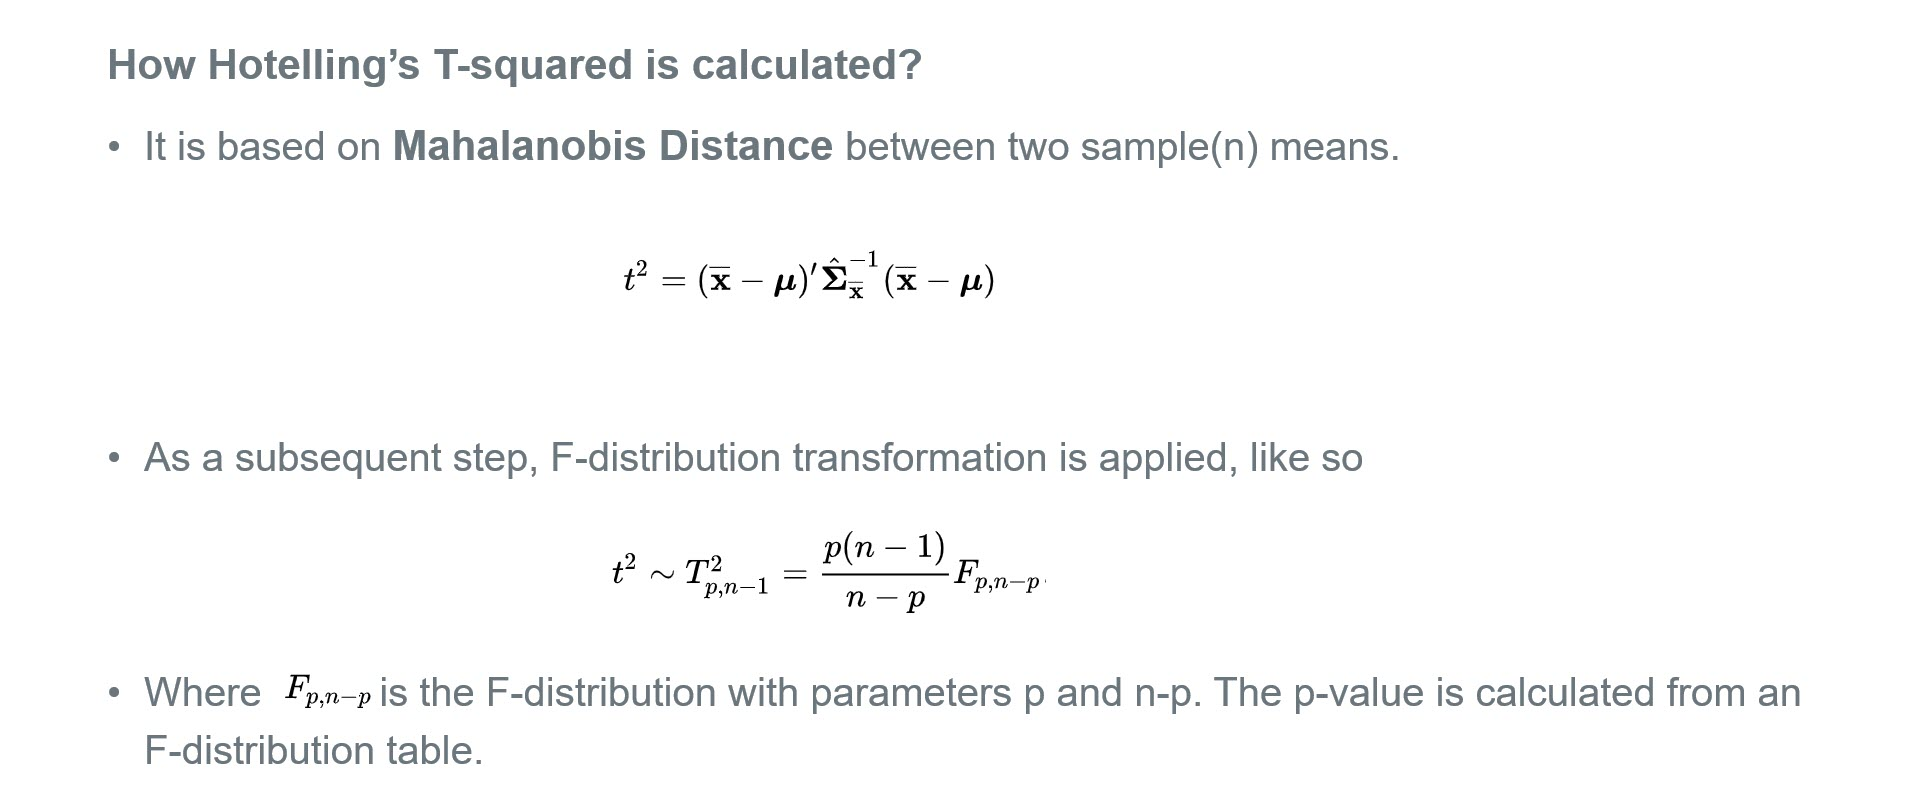

### Implementation 

### Calculate P-Values using Hoteling T-Squared 
- calculate hoteling t-squared probabilities using F distribution
- distance and p-values (for that distance) are joined in existing dataframe with the corresponding points
- save results in a csv

In [104]:

# set probabilities in hoteling's T-squared
md_prob = [calc_p_hoteling_t2([pdMultiData['FR'].iloc[idx], pdMultiData['FL'].iloc[idx], pdMultiData['RR'].iloc[idx], pdMultiData['RL'].iloc[idx]], n, k, pd_data_mean, S) for idx in range(pdMultiData.shape[0])]
md_prob = np.array(md_prob)

pd_outliers_t2 = pd.DataFrame({'distance':md_prob[:,0],'p-value':md_prob[:,1]})
pd_outliers_t2.index = pdMultiData.index
# df_pvalues.to_csv(data_dir + data_output_file, index = False)

# pd_outliers = pd_outliers[pd_outliers['p-value'] < 0.05].dropna()
pd_outliers_t2['outlier'] = np.where(pd_outliers_t2['p-value'] < 0.05, 1, 0)
# pd_outliers
pd_outliers_t2 = pd_outliers_t2.join(pdMultiData)
pd_outliers_t2 = pd_outliers_t2.join(data_sampled[['Steering_Wheel_Absolute_Angle', 'Acceleration_Sensor_Value', 'Yaw_Rate', 'Lateral_Sensor_Value', 'Vehicle_Speed']])

pd_outliers_t2.sort_values(['distance', 'p-value'], ascending = False).to_csv("../Suzuki/outliers_md_t2.csv")

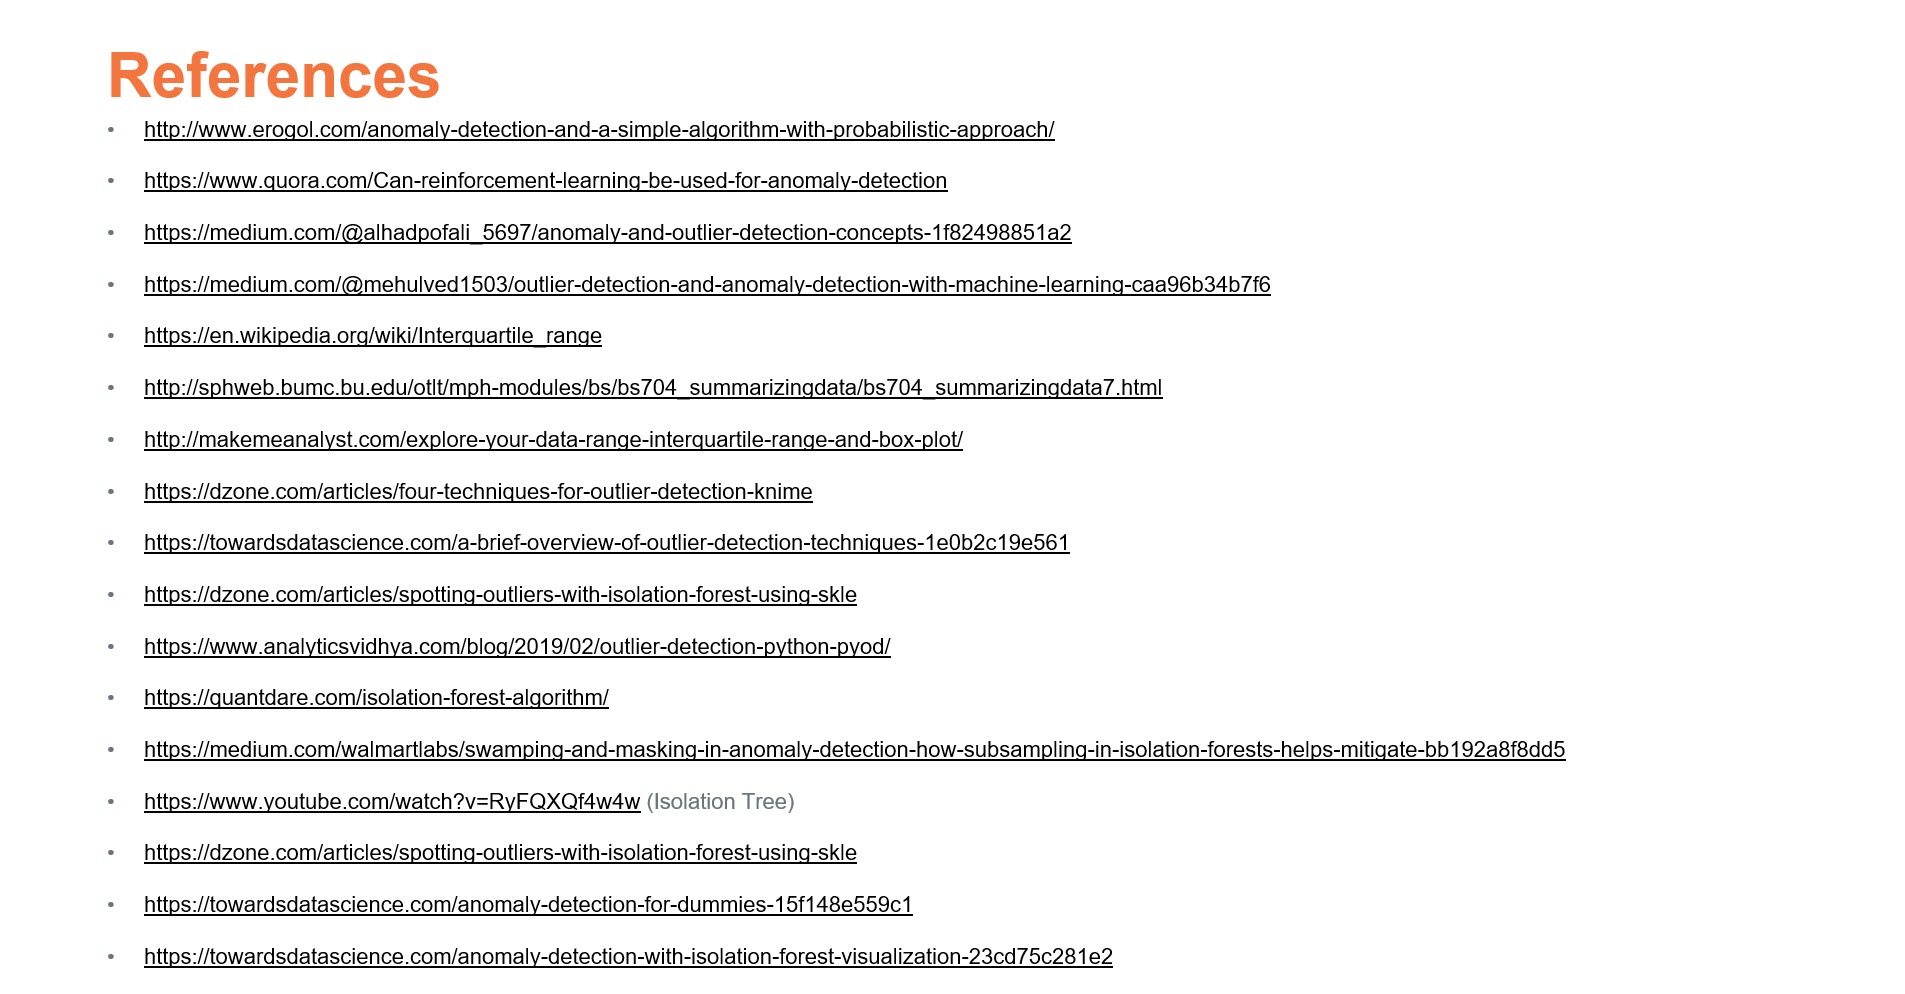

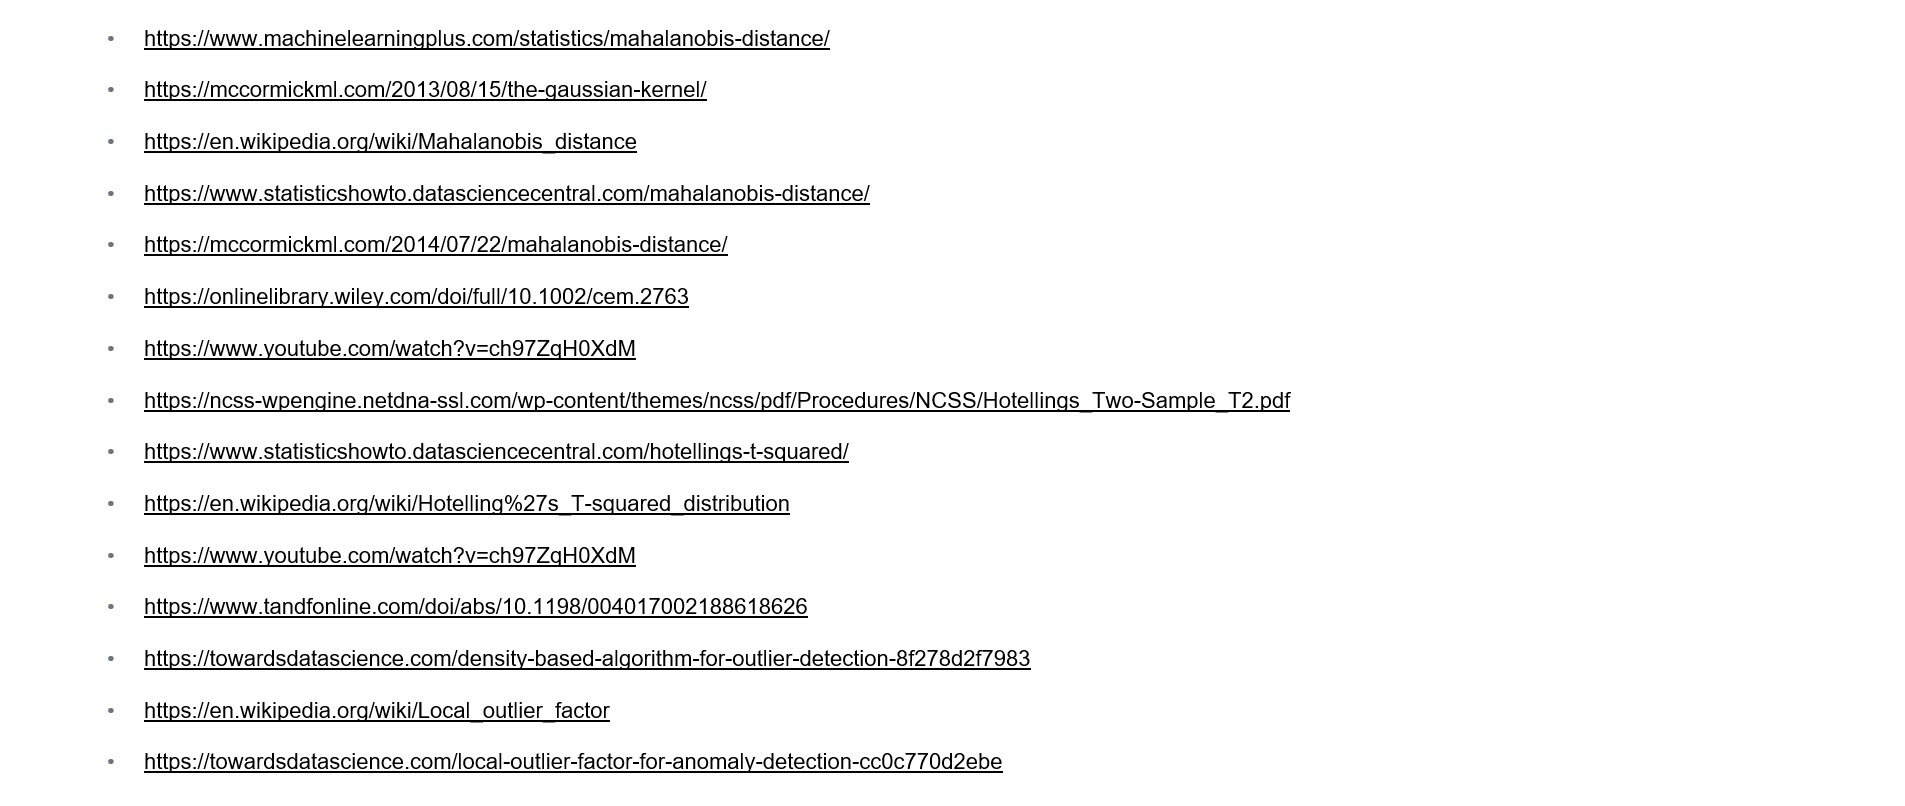